<div class="alert alert-block alert-info">
<center> <h1> Text Mining - Predicting Airbnb Unlisting </h1> </center> <br>
    
    
<center>University: NOVA Information Management School</center> <br>
<center>Program: Master’s Degree Program in Data Science and Advanced Analytics</center> <br>
<center>Academic Year: 2022/2023</center> <br>
<center> Group 17 </center> <br>
<center>======================== Students ========================</center> <br>
<center> Iryna Savchuk (m20211310@novaims.unl.pt) </center> <br>
<center> Cátia Parrinha (m20201320@novaims.unl.pt) </center> <br>
<center> Pedro Anastácio (m20180040@novaims.unl.pt) </center> <br>
<center>==========================================================</center> <br>

**Table of Contents** <br>
* [1.Data Import](#dataimport)
    * [1.1.Import Libraries](#importlibraries)
    * [1.2.Import Datasets](#importdatasets)
        * [1.2.1. Airbnb](#airbnb)
        * [1.2.2. Reviews](#reviews)
* [2.Data Exploration](#dataexploration)
    * [2.1. Checking shapes](#traindataset)
    * [2.2. Data Profiling](#dataprofiling)
    * [2.3. Missing Values](#missingvalues)
    * [2.4. Target exploration](#targetexploration)
    * [2.5. Text Features Data Exploration](#independentdataexploration)
        * [2.5.1. Word Counts](#wordcounts)
        * [2.5.2. Word Clouds](#wordcoulds)
        * [2.5.3. Duplicates](#duplicates)
        * [2.2.4. Explore Languages](#language)
        * [2.5.5. Summary of Exploratory Analysis](#summary)
* [3.Data Preprocessing - Train data](#datapreprocessing)
    * [3.1. Removing HTML Tags](#html)
    * [3.2. Translation](#translation)
    * [3.3. Cleaning](#cleaning)
    * [3.4. Aggregating Reviews](#prep_reviews)
* [4.Feature Engineering](#training_features)
    * [4.1. Train / Validation Split](#split)
    * [4.2. Bag of Words (BoW)](#bow)
    * [4.3. TF_IDF](#tf-idf)
        * [4.3.1. 1 Gram](#1gram)
        * [4.3.2. 1 and 2 Gram](#12gram)        
    * [4.4. Hashing Vectorizer](#hashing)
    * [4.5. Custom Features](#custom)
        * [4.5.1. Feature Engineering based on Counting](#custom_counts)
        * [4.5.2. Extracting Numeric Info from 'description'](#custom_numeric)
        * [4.5.3. Sentiment Scores for Reviews](#custom_sentiment)
        * [4.5.4. Merging and Scaling Custom Features ](#custom_merge)
    
* [5. Classification Models](#classificationmodels)
    * [5.1. KNeighborsClassifier](#KNN)
        * [5.1.1. BoW](#KNN_bow)
        * [5.1.2. TF-IDF (1-Gram)](#KNN_tfidf-1gram)   
        * [5.1.3. TF-IDF (2-Gram)](#KNN_tfidf-2gram)
        * [5.1.4. Hashing Vectorizer](#KNN-hash)
        * [5.1.5. Custom Features](#KNN-custom)
    * [5.2. Random Forest](#randomforest)
        * [5.2.1. BoW](#randomforest_bow)
        * [5.2.2. TF-IDF (1-Gram)](#randomforest_tfidf-1gram)
        * [5.2.3. TF-IDF (2-Gram)](#randomforest_tfidf-2gram)
        * [5.2.4. Hashing Vectorizer](#randomforest_hash)
        * [5.2.5. Custom Features](#randomforest_custom)
    * [5.3. Logistic Regression](#logisticregression)
        * [5.3.1 BoW](#lr_bow)
        * [5.3.2. TF-IDF (1-Gram)](#log_1gram)
        * [5.3.3. TF-IDF (2-Gram)](#log_2gram)
        * [5.3.4. Hashing Vectorizer](#log_hash)
        * [5.3.5. Custom Features](#log_custom)
    * [5.4. Neural Networks](#nn)
        * [5.4.1. BoW](#nn_bow)  
        * [5.4.2. TF-IDF (1-Gram)](#nn_1gram)
        * [5.4.3. TF-IDF (2-Gram)](#nn_2gram)
        * [5.4.4. Hashing Vectorizer](#nn_hash)
        * [5.4.5. Custom Features](#nn_custom)
    * [5.5. XGBoost model](#xgboost)
        * [5.5.1. BoW](#boost_bow)  
        * [5.5.2. TF-IDF (1-Gram)](#boost_1gram)
        * [5.5.3. TF-IDF (2-Gram)](#boost_2gram)
        * [5.5.4. Hashing Vectorizer](#boost_hash)
        * [5.5.5. Custom Features](#boost_custom)
    * [5.6. Grid Search](#gridsearch)
* [6. Test](#test)

<hr>
<a class="anchor" id="dataimport">
    
# 1. Data Import
    
</a>

<hr>
<a class="anchor" id="importlibraries">
    
## 1.1. Import Libraries
    
</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm    # colormaps for matplotlib
from wordcloud import WordCloud
import csv
import os
from tqdm import tqdm  # progress bars during iterative tasks


# Profiling Report
from ydata_profiling import ProfileReport

# For Cleaning Data
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
import re     
import nltk
from nltk.tokenize import word_tokenize  # Tokenization
from nltk.stem import SnowballStemmer   # Stemming
from nltk.stem.wordnet import WordNetLemmatizer  # Lemmatization

# Language detector
from langdetect import detect

# Translate emoji to text
import demoji

# Vectorizers
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.feature_extraction.text import HashingVectorizer # Hashing Vectorizer

# Sentiment Scores Calculation
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline   # 'sentiment-analysis' pipeline will be used
from transformers import DistilBertTokenizerFast

# Scalers
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Evaluate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Data Partition
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import xgboost as xgb

# Fine Tuning
from sklearn.model_selection import GridSearchCV

# To filter warnings
import warnings
warnings.filterwarnings("ignore")

<hr>
<a class="anchor" id="importdatasets">
    
## 1.2. Import Datasets
    
</a>

<hr>
<a class="anchor" id="airbnb">
    
### 1.2.1. Airbnb
    
</a>

In [2]:
airbnb_df_train = pd.read_excel('Project Corpora/train.xlsx')
airbnb_df_train.head(3)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1


In [3]:
airbnb_df_test = pd.read_excel('Project Corpora/test.xlsx')
airbnb_df_test.head(3)

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."


<hr>
<a class="anchor" id="reviews">
    
### 1.2.2. Reviews
    
</a>

In [4]:
reviews_df_train = pd.read_excel('Project Corpora/train_reviews.xlsx')
reviews_df_train.head(3)

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."


In [5]:
reviews_df_test = pd.read_excel('Project Corpora/test_reviews.xlsx')
reviews_df_test.head(3)

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...


<hr>
<a class="anchor" id="dataexploration">
    
# 2. Data Exploration
    
</a>

<hr>
<a class="anchor" id="traindataset">
    
## 2.1. Checking shapes
    
</a>

In [6]:
print("Train shape:", airbnb_df_train.shape)
print("Train reviews shape:", reviews_df_train.shape)
print("------------------")
print("Test shape:", airbnb_df_test.shape)
print("Test reviews shape:", reviews_df_test.shape)

Train shape: (12496, 4)
Train reviews shape: (721402, 2)
------------------
Test shape: (1389, 3)
Test reviews shape: (80877, 2)


<hr>
<a class="anchor" id="dataprofiling">
    
## 2.2. Data Profiling
</a>

In [7]:
# Generate a profile report for the the train DataFrame and save it to /output
profile = ProfileReport(airbnb_df_train, title="Profiling Report")
profile.to_file("output/airbnb_report.html")

# Reset the matplotlib backend for the rest of the notebook
plt.switch_backend("module://ipykernel.pylab.backend_inline")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<hr>
<a class="anchor" id="missingvalues">
    
## 2.3. Missing Values
    
</a>

In [8]:
airbnb_df_train.isna().sum()

df_index       0
description    0
host_about     0
unlisted       0
dtype: int64

<div class="alert alert-block alert-success">
    There are no missing values in the <b> airbnb train </b> dataset columns.

In [9]:
reviews_df_train.isna().sum()

index       0
comments    0
dtype: int64

<div class="alert alert-block alert-success">
    There are no missing values in the <b> review train </b> dataset.

<hr>
<a class="anchor" id="targetexploration">
    
## 2.4. Target exploration
    
</a>

Check unique values for the target labels:

In [10]:
(airbnb_df_train['unlisted']).unique()

array([0, 1])

In [11]:
airbnb_df_train['unlisted'].value_counts()

0    9033
1    3463
Name: unlisted, dtype: int64

Nevertheless, it is better to visualize labels proportions:

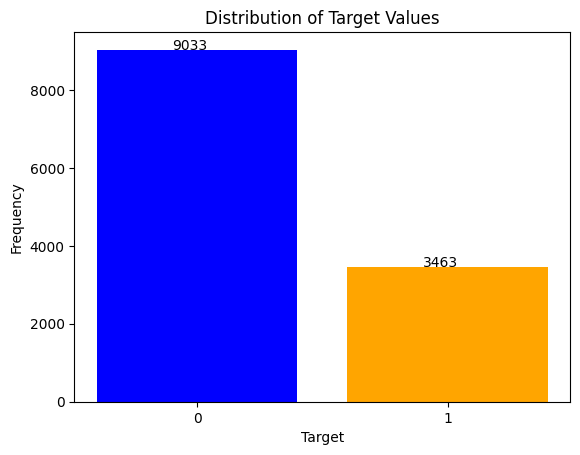

In [12]:
# Calculate the frequency of each rating
counts = airbnb_df_train['unlisted'].value_counts()

# Create a bar chart of the ratings
colors = ['blue', 'orange']
plt.bar(counts.index, counts.values, color=colors)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Distribution of Target Values')
plt.xticks(range(0, 2))

# Add the value of each bar to the plot
for i, v in enumerate(counts.values):
    plt.text(counts.index[i] - 0.1, v + 0.1, str(v))

plt.show()

In [13]:
airbnb_df_train['unlisted'].value_counts(normalize = True)

0    0.722871
1    0.277129
Name: unlisted, dtype: float64

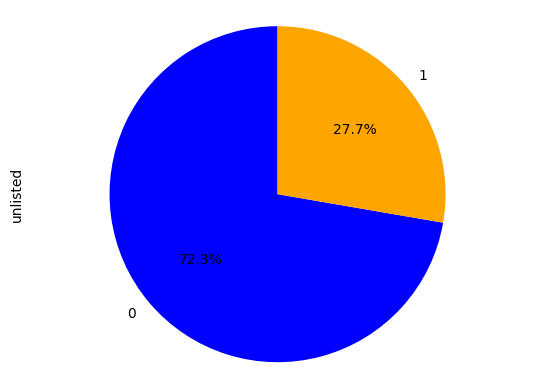

In [14]:
airbnb_df_train['unlisted'].value_counts().plot(kind='pie', 
                                             labels=airbnb_df_train['unlisted'].unique(), 
                                             autopct='%1.1f%%', 
                                             startangle=90, colors=colors)
plt.axis('equal')
plt.show()

<div class="alert alert-block alert-danger">  
The <b> train </b> dataset has an unbalanced target variable, with 72.3% of values being '0' and the rest of the values being '1'.
</div>

<hr>
<a class="anchor" id="independentdataexploration">
    
## 2.5. Text Features exploration
    
</a>

We have 2 textual columns in the train dataset ("description" and "host_about") and one textual column in the reviews dataset ("comments"). 

Let us do an Exploratory Analysis of these three features.

<hr>
<a class="anchor" id="wordcounts">
    
### 2.5.1. Word Counts
    
</a>

We will split our texts into tokens and count how many tokens exist in each document.

**description**

In [15]:
airbnb_df_train['word_count_description']  = airbnb_df_train['description'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['description','word_count_description']].head()

,description,word_count_description
0,"This is a shared mixed room in our hostel, wit...",127
1,"O meu espaço fica perto de Parque Eduardo VII,...",23
2,Trafaria’s House is a cozy and familiar villa ...,170
3,"Apartamento Charmoso no Chiado, Entre o Largo ...",47
4,Joli appartement en bordure de mer.<br /> 2 m...,101


Descriptive Statistics of word count

In [16]:
airbnb_df_train.word_count_description.describe()

count    12496.000000
mean       132.663572
std         48.494104
min          3.000000
25%         99.000000
50%        157.000000
75%        167.000000
max        210.000000
Name: word_count_description, dtype: float64

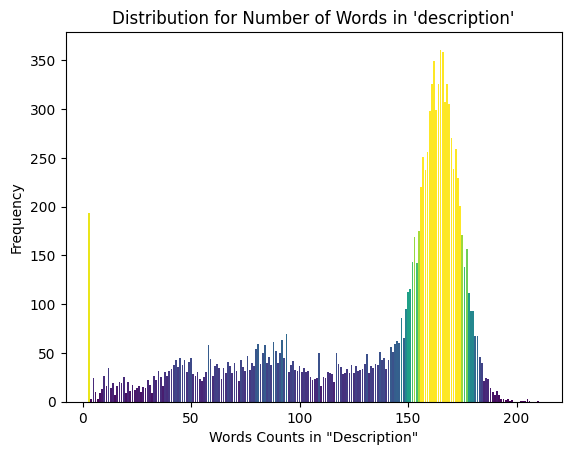

In [17]:
# Calculate the frequency of each rating
counts_desc = airbnb_df_train['word_count_description'].value_counts()

# Create a colormap based on the frequencies
colormap = cm.get_cmap('viridis', len(counts_desc))

# Create a bar chart of the ratings
plt.bar(counts_desc.index, counts_desc.values, color=colormap(counts_desc.values))
plt.xlabel('Words Counts in "Description"')
plt.ylabel('Frequency')
plt.title("Distribution for Number of Words in 'description'")

plt.show()

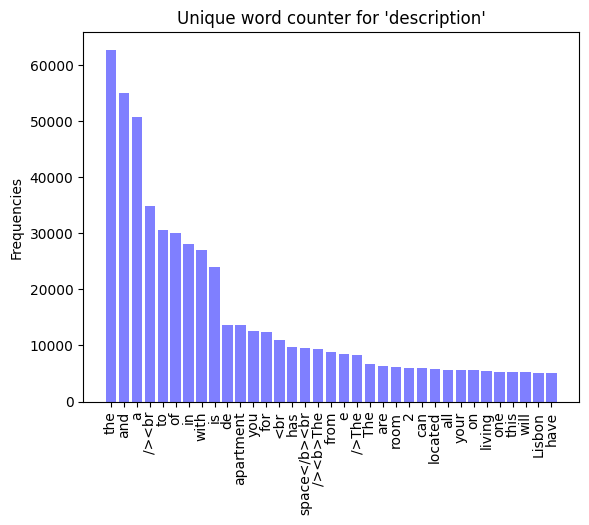

In [18]:
# Create a list with all words in airbnb_df_train['description']
all_words_desc = ' '.join(airbnb_df_train['description']).split()
# The frequency of each word
freq_desc = pd.Series(all_words_desc).value_counts()

# A bar plot with the top 35 words, from description column
x_labels = freq_desc.index[0:35]
values = freq_desc[:35]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'blue')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title("Unique word counter for 'description'")
plt.xticks(rotation=90)
plt.show()

**host_about**

In [19]:
airbnb_df_train['word_count_host_about']  = airbnb_df_train['host_about'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['host_about','word_count_host_about']].head()

,host_about,word_count_host_about
0,Alojamento Local Registro: 20835/AL,4
1,"I am friendly host, and I will try to always b...",24
2,"I am a social person liking to communicate, re...",45
3,Hello!_x000D_\nI m Portuguese and i love to me...,31
4,Nous sommes une famille avec deux enfants de 1...,37


Descriptive Statistics of word count

In [20]:
airbnb_df_train.word_count_host_about.describe()

count    12496.000000
mean        73.031050
std         77.132867
min          1.000000
25%         26.000000
50%         55.000000
75%        102.000000
max       1387.000000
Name: word_count_host_about, dtype: float64

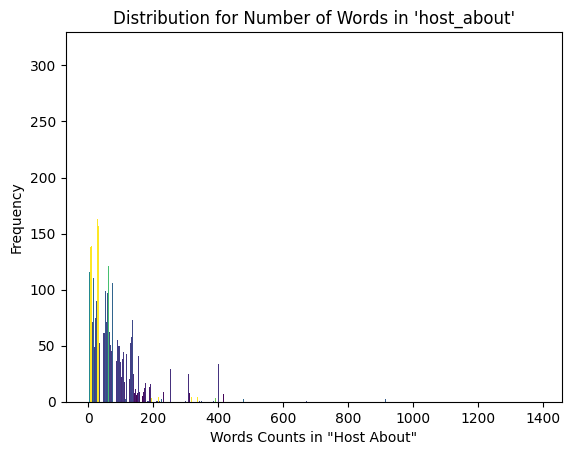

In [21]:
# Calculate the frequency of each rating
counts_host = airbnb_df_train['word_count_host_about'].value_counts()

# Create a colormap based on the frequencies
colormap = cm.get_cmap('viridis', len(counts_desc))

# Create a bar chart of the ratings
plt.bar(counts_host.index, counts_host.values, color=colormap(counts_desc.values))
plt.xlabel('Words Counts in "Host About"')
plt.ylabel('Frequency')
plt.title("Distribution for Number of Words in 'host_about'")

plt.show()

In [22]:
# Exploring extreme values:
airbnb_df_train[airbnb_df_train['word_count_host_about'] > 800][['host_about', 'word_count_host_about']]

,host_about,word_count_host_about
1419,life is so much more then nice words and so ca...,922
2244,Travel is life ! I love meeting people and hel...,1387
3950,life is so much more then nice words and so ca...,922
5200,life is so much more then nice words and so ca...,922
7197,"Portuguese-Mozambican, born in Beira, Mozambiq...",864
7943,"Hi, \nMy name is Ralph Mason, I'm a '40 someth...",915
8126,"Hi, \nMy name is Ralph Mason, I'm a '40 someth...",915
9714,Travel is life ! I love meeting people and hel...,1387


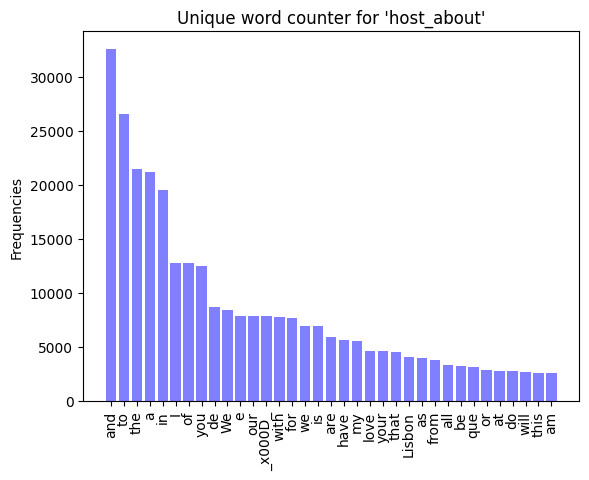

In [23]:
# Create a list with all words in airbnb_df_train['hoost_about']
all_words_host = ' '.join(airbnb_df_train['host_about']).split()
# The frequency of each word
freq_host = pd.Series(all_words_host).value_counts()

# A bar plot with the top 35 words, for 'host_about' column
x_labels = freq_host.index[0:35]
values = freq_host[:35]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'blue')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title("Unique word counter for 'host_about'")
plt.xticks(rotation=90)
plt.show()

**comments**

In [24]:
reviews_df_train['word_count_comments']  = reviews_df_train['comments'].apply(lambda x: len(str(x).split(" ")))
reviews_df_train[['comments','word_count_comments']].head()

,comments,word_count_comments
0,this is a very cozy and comfortable house to s...,28
1,good<br/>,1
2,"My first hostel experience, and all I have to ...",261
3,Das Hostel war neu und deshalb funktionierte a...,81
4,"It was fine for a dorm, but I think for the pe...",27


In [25]:
reviews_df_train.word_count_comments.describe()

count    721402.000000
mean         47.993793
std          46.922807
min           1.000000
25%          18.000000
50%          36.000000
75%          63.000000
max        1064.000000
Name: word_count_comments, dtype: float64

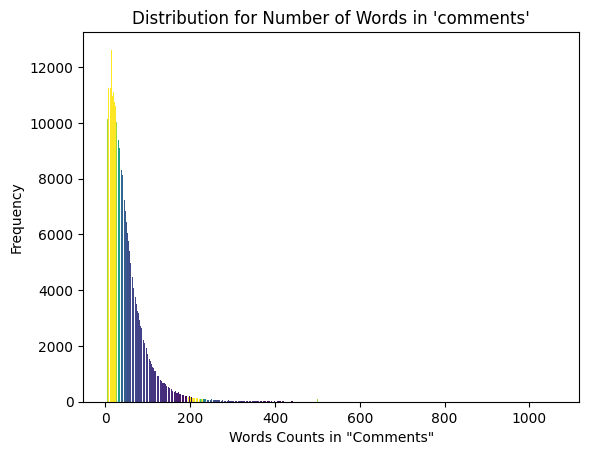

In [26]:
# Calculate the frequency of each rating
counts_host = reviews_df_train['word_count_comments'].value_counts()

# Create a colormap based on the frequencies
colormap = cm.get_cmap('viridis', len(counts_desc))

# Create a bar chart of the ratings
plt.bar(counts_host.index, counts_host.values, color = colormap(counts_desc.values))
plt.xlabel('Words Counts in "Comments"')
plt.ylabel('Frequency')
plt.title("Distribution for Number of Words in 'comments'")

plt.show()

In [27]:
# Exploring extreme values:
reviews_df_train[reviews_df_train['word_count_comments'] > 1000][['comments', 'word_count_comments']]

,comments,word_count_comments
120285,This is the first bad review I have ever writt...,1019
145075,"Longe de atender minhas espectativas, vou come...",1005
174862,We strongly recommend Villa Roma Townhouse/Apt...,1003
408765,"The apartment is nice and the view is amazing,...",1007
478814,This feedback and review is based on our stay ...,1064
498296,Summary: In my 7 years of being an airbnb gues...,1001


In [28]:
# Checking if there are rows where 'comments' is numberic
numeric_column = pd.to_numeric(reviews_df_train['comments'], errors='coerce')
numeric_rows = reviews_df_train[~numeric_column.isna()] # rows with successful conversion
numeric_rows.head()

,index,comments,word_count_comments
26593,468,10,1
62305,1062,1,1
83596,1397,1,1
160070,2696,0,1
211858,3593,9,1


In [29]:
reviews_df_train['comments'] = reviews_df_train['comments'].astype('string')

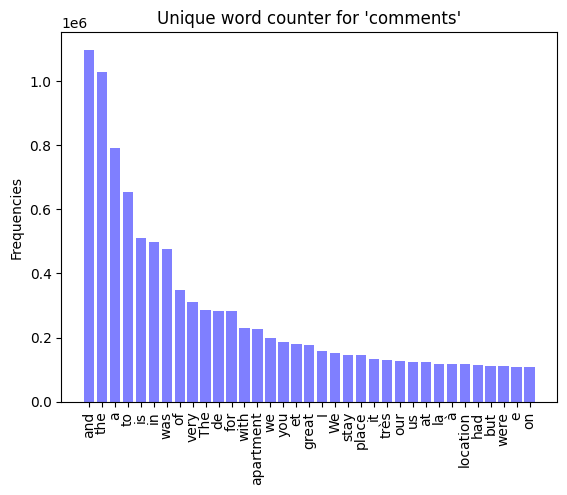

In [30]:
# Create a list with all words in reviews_df_train['comments']
all_words_comments = ' '.join(reviews_df_train['comments']).split()
# The frequency of each word
freq_host = pd.Series(all_words_comments).value_counts()

# A bar plot with the top 35 words, for 'comments' column
x_labels = freq_host.index[0:35]
values = freq_host[:35]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'blue')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title("Unique word counter for 'comments'")
plt.xticks(rotation=90)
plt.show()

<hr>
<a class="anchor" id="wordcoulds">
    
### 2.5.2. Word Clouds
    
</a>

**description**

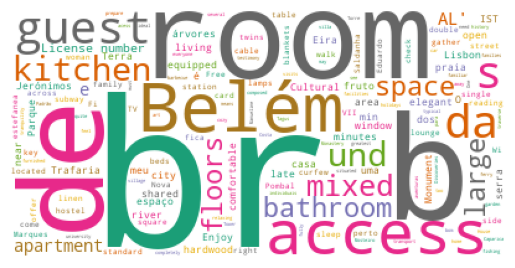

In [31]:
# Word Cloud of the feature "description" from airbnb_df_train
wordcloud = WordCloud(
    background_color='white', 
    max_words=500, 
    colormap='Dark2',
    contour_width=4).generate(str(airbnb_df_train["description"].values))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**host_about**

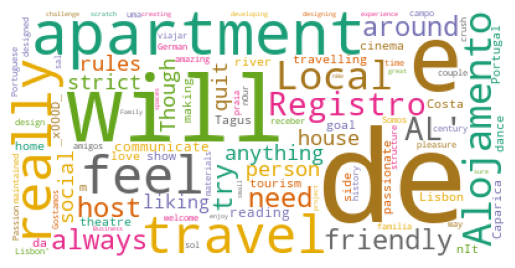

In [32]:
# Word Cloud of the feature "host_about" from airbnb_df_train
wordcloud = WordCloud(
    background_color='white', 
    max_words=500, 
    colormap='Dark2',
    contour_width=4).generate(str(airbnb_df_train["host_about"].values))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**comments**

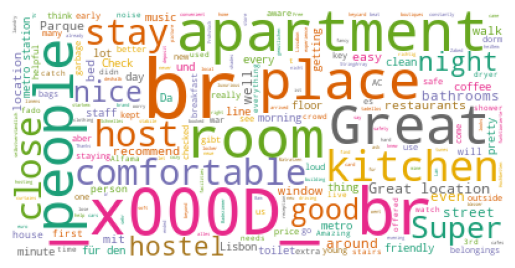

In [33]:
# Word Cloud of the feature "comments" from df_train
wordcloud = WordCloud(
    background_color='white', 
    max_words=500, 
    colormap='Dark2',
    contour_width=4).generate(str(reviews_df_train["comments"].values))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<hr>
<a class="anchor" id="duplicates">
    
### 2.5.3. Duplicates
    
</a>

In [34]:
# Checking for duplicated values in the airbnb_df_train rows
airbnb_df_train.duplicated(subset=['description', 'host_about']).any()

True

In [35]:
# Compare the number of duplicates with the total number of rows
duplicated_rows = airbnb_df_train[airbnb_df_train.duplicated(subset=['description', 'host_about'])]
num_duplicated_rows = duplicated_rows.shape[0]
total_rows = airbnb_df_train.shape[0]

print("Number of duplicated rows in airbnb_df_train:", num_duplicated_rows)
print("Total number of rows in airbnb_df_train:", total_rows)

Number of duplicated rows in airbnb_df_train: 642
Total number of rows in airbnb_df_train: 12496


In [36]:
# What percentage of the rows are duplicates
duplicate_percentage = airbnb_df_train.duplicated(subset=['description', 'host_about']).mean() * 100
print(f"The percentage of duplicate rows in df_train is: {duplicate_percentage:.2f}%")

The percentage of duplicate rows in df_train is: 5.14%


In [37]:
# Having a look at the specific duplicated value:
specific_description_sample = '<b>Other things to note</b><br />For your information, we are carrying out work in the '\
    'apartment and because of this the kitchen will not be available, for the month of February there will be men working from '\
    '9 am to 5 pm. To compensate, you pay much less than -50% of the price usual.<br /><br /><b>License number</b><br />104691/AL'

airbnb_df_train.loc[airbnb_df_train['description']==specific_description_sample]

,df_index,description,host_about,unlisted,word_count_description,word_count_host_about
92,93,<b>Other things to note</b><br />For your info...,.,1,57,1
5352,5353,<b>Other things to note</b><br />For your info...,.,0,57,1
9285,9286,<b>Other things to note</b><br />For your info...,.,1,57,1


<hr>
<a class="anchor" id="language">
    
### 2.5.4. Explore Languages
    
</a>

In [38]:
# Define a function to detect the language of a string
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = None
    return lang

In [40]:
# Saving dataframe to .csv to later read it by chunks
airbnb_df_train.to_csv('output/train.csv', index=False)

In [41]:
# Detecting languages in the Train dataset >>>>>>>>>>>>>>>>>> RUN THIS ONLY ONCE: IT APPENDS IN THE END OF FILE
source_file = 'output/train.csv'
destination_file = 'output/train_with_language.csv'

chunk_size = 300
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    chunk['description'] = chunk['description'].str.replace('<br/>', '')
    chunk['description'] = chunk['description'].str.replace('x000D', '')
    chunk['description_language'] = chunk['description'].apply(detect_language)
    
    chunk['host_about'] = chunk['host_about'].str.replace('<br/>', '')
    chunk['host_about'] = chunk['host_about'].str.replace('x000D', '')
    chunk['host_about_language'] = chunk['host_about'].apply(detect_language)
    
    chunk.to_csv(destination_file, 
                 index=False, 
                 mode='a', 
                 header=not os.path.exists(destination_file))

42it [01:03,  1.51s/it]


In [43]:
reviews_df_train.to_csv('output/train_reviews.csv', index=False)

In [44]:
# Detecting languages in the Reviews dataset >>>>>>>>>>>>>>>>>> RUN THIS ONLY ONCE: IT APPENDS IN THE END OF FILE
source_file = 'output/train_reviews.csv'
destination_file = 'output/train_reviews_with_language.csv'

chunk_size = 300
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    chunk['comments'] = chunk['comments'].str.replace('<br/>', '')
    chunk['comments'] = chunk['comments'].str.replace('x000D', '')
    chunk['comments_language'] = chunk['comments'].apply(detect_language)
    
    chunk.to_csv(destination_file, 
                 index=False, 
                 mode='a', 
                 header=not os.path.exists(destination_file))

2405it [22:25,  1.79it/s]


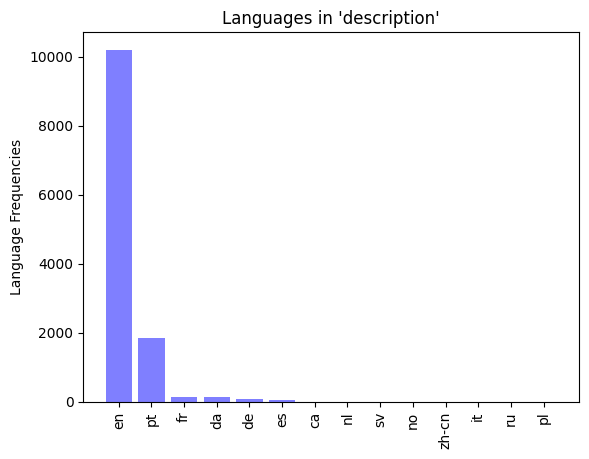

In [39]:
# Checking frequencies for languages in "description"
airbnb_language_df = pd.read_csv('output/train_with_language.csv')
freq = pd.Series(airbnb_language_df['description_language']).value_counts()
x_labels = freq.index[0:20]
values = freq[:20]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'blue')
plt.ylabel('Language Frequencies')
plt.title("Languages in 'description'")
plt.xticks(rotation=90)
plt.show()

In [44]:
# Calculate the language percentages - 'description'
language_percentages = airbnb_language_df['description_language'].value_counts(normalize=True) * 100

# Create a new DataFrame with language percentages
language_df = pd.DataFrame({'Language': language_percentages.index, 'Percentage': language_percentages.values})

# Group languages as 'Other Language' if not 'en', 'pt', or 'fr'
language_df.loc[~language_df['Language'].isin(['en', 'pt', 'fr']), 'Language'] = 'Other Languages'

# Calculate the percentage of 'en', 'pt', 'fr' and 'Other Language' combined
combined_description_percentage = language_df.groupby('Language')['Percentage'].sum().reset_index()

# Sort the DataFrame by percentage in descending order
combined_description_percentage = combined_description_percentage.sort_values('Percentage', ascending=False)

# Reset the index of the DataFrame
combined_description_percentage.reset_index(drop=True, inplace=True)
combined_description_percentage

,Language,Percentage
0,en,81.650128
1,pt,14.740717
2,Other Languages,2.376761
3,fr,1.232394


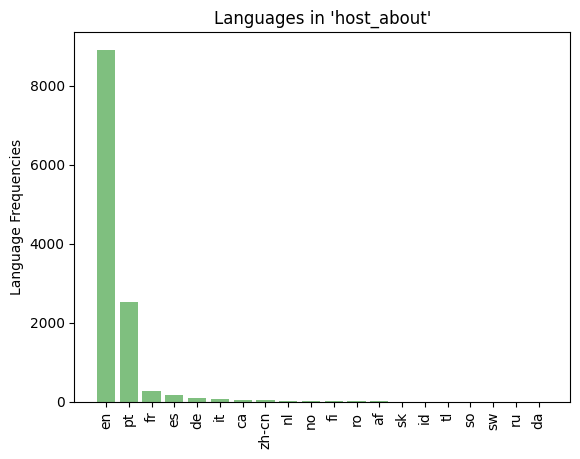

In [45]:
# Checking frequencies for languages in "host_about"
freq = pd.Series(airbnb_language_df['host_about_language']).value_counts()
x_labels = freq.index[0:20]
values = freq[:20]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'green')
plt.ylabel('Language Frequencies')
plt.title("Languages in 'host_about'")
plt.xticks(rotation=90)
plt.show()

In [46]:
# Calculate the language percentages - 'host_about'
host_language_percentages = airbnb_language_df['host_about_language'].value_counts(normalize=True) * 100

# Create a new DataFrame with language percentages
host_language_df = pd.DataFrame({'Language': host_language_percentages.index, 'Percentage': host_language_percentages.values})

# Group languages as 'Other Language' if not 'en', 'pt', or 'fr'
host_language_df.loc[~host_language_df['Language'].isin(['en', 'pt', 'fr']), 'Language'] = 'Other Languages'

# Calculate the percentage of 'en', 'pt', 'fr' and 'Other Language' combined
combined_percentage = host_language_df.groupby('Language')['Percentage'].sum().reset_index()

# Sort the DataFrame by percentage in descending order
combined_percentage = combined_percentage.sort_values('Percentage', ascending=False)

# Reset the index of the DataFrame
combined_percentage.reset_index(drop=True, inplace=True)
combined_percentage

,Language,Percentage
0,en,72.170882
1,pt,20.403696
2,Other Languages,5.220493
3,fr,2.204929


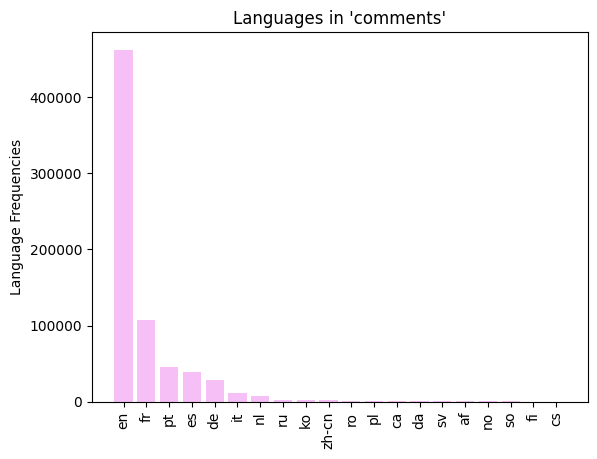

In [47]:
# Checking frequencies for languages in "comments"
reviews_languages_df = pd.read_csv('output/train_reviews_with_language.csv')
freq = pd.Series(reviews_languages_df['comments_language']).value_counts()
x_labels = freq.index[0:20]
values = freq[:20]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'violet')
plt.ylabel('Language Frequencies')
plt.title("Languages in 'comments'")
plt.xticks(rotation=90)
plt.show()

In [48]:
# Calculate the language percentages - 'comments'
comments_language_percentages = reviews_languages_df['comments_language'].value_counts(normalize=True) * 100

# Create a new DataFrame with language percentages
comments_language_df = pd.DataFrame({'Language': comments_language_percentages.index, 'Percentage': comments_language_percentages.values})

# Group languages as 'Other Language' if not 'en', 'pt', or 'fr'
comments_language_df.loc[~comments_language_df['Language'].isin(['en', 'pt', 'fr']), 'Language'] = 'Other Languages'

# Calculate the percentage of 'en', 'pt', 'fr' and 'Other Language' combined
combined_percentage = comments_language_df.groupby('Language')['Percentage'].sum().reset_index()

# Sort the DataFrame by percentage in descending order
combined_percentage = combined_percentage.sort_values('Percentage', ascending=False)

# Reset the index of the DataFrame
combined_percentage.reset_index(drop=True, inplace=True)
combined_percentage

,Language,Percentage
0,en,64.172583
1,fr,14.877922
2,Other Languages,14.598733
3,pt,6.350761


In [49]:
description_languages = set(airbnb_language_df['description_language'])
print("description_languages:", description_languages)
print("total number:", len(description_languages))
print("-----------------")
host_about_languages = set(airbnb_language_df['host_about_language'])
print("host_about_languages:", host_about_languages)
print("total number:", len(host_about_languages))
print("-----------------")
comments_languages = set(reviews_languages_df['comments_language'])
print("comments_languages:", comments_languages)
print("total number:", len(comments_languages))

description_languages: {'pl', 'en', 'no', 'da', 'sv', 'fr', 'ru', 'zh-cn', 'pt', 'nl', 'de', 'ca', 'es', 'it'}
total number: 14
-----------------
host_about_languages: {'sv', 'hu', 'zh-cn', 'ro', 'sk', 'zh-tw', 'sw', 'it', 'ko', 'fi', 'af', 'vi', 'ca', 'id', 'tr', 'en', 'he', 'et', 'pt', 'nl', 'no', 'lt', 'da', 'fr', 'tl', 'de', nan, 'sl', 'cs', 'es', 'so', 'ru'}
total number: 32
-----------------
comments_languages: {'sv', 'hu', 'zh-cn', 'sq', 'ro', 'sk', 'hi', 'lv', 'hr', 'zh-tw', 'ar', 'sw', 'it', 'ko', 'th', 'fi', 'ja', 'af', 'id', 'ca', 'vi', 'tr', 'uk', 'el', 'en', 'he', 'et', 'mk', 'pt', 'cy', 'nl', 'ne', 'no', 'lt', 'ur', 'pl', 'da', 'fr', 'tl', 'bg', 'de', nan, 'cs', 'sl', 'es', 'so', 'ru'}
total number: 47


<hr>
<a class="anchor" id="summary">
    
### 2.5.5. Summary of Exploratory Analysis
    
</a>

The original 'train.xlsx' file contains 12,496 rows and 4 columns: 'index', 'description', 'host_about', and 'unlisted'. The 'unlisted' column is the target variable and will be predicted based on other values.

The file 'train_reviews.xlsx' contains 721,402 rows and 2 columns: 'index' and 'comments'. We will use 'index' to merge information when creating the features.

During this step, we counted the number of words in each text column. For the description column, the number of words is at most 210 words, with the most frequent value being between 150 and 180 words. For host_about, it is usually less than 200 words, but there are long values, some of them over 1000 words. For comments, it is usually less than 200 words, but again there are long values, over 1000 words. We will need to deal with these extreme values during the features engineering step.

Based on the word clouds, it can be seen that the given dataset contains languages other than English - at least Portuguese(see the words like 'de', 'e', 'Alojamento', 'Belém', 'praia') and German('und', 'ist' and others). Also, there are several tags (such as "\<br />" and "\<b>") in our data as well as sequences of characters that are obtained after import from an Excel file (such as "x000D\n"). Thus, we will need to perform text cleaning.
 
The dataset does not have any empty values.

Some rows have the same values for the 'description' and 'host_about' columns, whereas 'unlisted' values differ. It means that using only 'train' dataset might not be enough for the project purpose, and we might want to utilize 'reviews' data as well.

For each column with text, there are different languages associated, mainly English and Portuguese.
In the description columns, it was detected 14 different languages, 82% English and 15% Portuguese. In host_about, there are 33 different languages, 72% English and 20% Portuguese. In comments, more than 40 languages, 64% English, 15% French, and 6% Portuguese.

<hr>
<a class="anchor" id="datapreprocessing">
    
# 3. Data Preprocessing - Train data
    
</a>

In [39]:
airbnb_language_df = pd.read_csv('output/train_with_language.csv')
reviews_languages_df = pd.read_csv('output/train_reviews_with_language.csv')

<hr>
<a class="anchor" id="html">
    
## 3.1. Removing HTML Tags
    
</a>

In [40]:
# Creating a function to remove HTML tags
def remove_HTML_tags(df, column):
    """Function that removes HTML tags from a column containing strings in a dataframe."""
    
    # Remove HTML tags from df[column] using BeautifulSoup
    df[column] = df[column].apply(lambda x: BeautifulSoup(x, "html.parser").get_text(separator=" ") if isinstance(x, str) else x)
    
    # Remove extra whitespaces and newline characters from df[column]
    df[column] = df[column].apply(lambda x: re.sub(r'\s+', ' ', x).strip() if isinstance(x, str) else x)
    
    return df

In [41]:
# Applying the function above to remove HTML tags 
clean_airbnb_df = remove_HTML_tags(airbnb_language_df, 'description')
clean_airbnb_df = remove_HTML_tags(clean_airbnb_df,'host_about')

clean_reviews_df = remove_HTML_tags(reviews_languages_df,'comments')

<hr>
<a class="anchor" id="translation">
    
## 3.2. Translation
    
</a>

The following transformer model will be used to translate non-English text into English:

https://huggingface.co/Helsinki-NLP/opus-mt-mul-en

Source group: 120 languages 

Target group: English

In [18]:
from transformers import MarianMTModel, MarianTokenizer

model_name = "Helsinki-NLP/opus-mt-mul-en"  # Multilingual to English translation model
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

# Define Translation Function
def translate_text_multilingual(text):
    input_ids = tokenizer.encode(text, return_tensors="pt")   # Tokenize the input text
    translated_ids = model.generate(input_ids)   # Perform translation
    translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True) # Decode the translated output
    return translated_text

# Function to split text into sentences using NLTK
def split_text_into_sentences(text):
    return nltk.sent_tokenize(text)

# Function to translate text using translate_text_multilingual()
def translate_text_chunks(text_chunks):
    translated_chunks = []
    for chunk in text_chunks:
        translated_chunk = translate_text_multilingual(chunk)
        translated_chunks.append(translated_chunk)
    return translated_chunks

In [79]:
## TIME CONSUMING STEP
## Translating 'description' column, creating a new column 'description_english' 

# Taking descriptions values and their detected languages
descriptions = clean_airbnb_df.description
description_languages = clean_airbnb_df.description_language

# Generating values for the new 'description_english' column
description_english = []

for i in tqdm(range(len(descriptions))):
    if description_languages[i] == 'en':
        description_english.append(descriptions[i])
    else:
        sentences = split_text_into_sentences(descriptions[i]) # Split text into sentences/chunks
        translated_sentences = translate_text_chunks(sentences) # Translate each sentence/chunk
        translated_output = " ".join(translated_sentences) # Merge translated sentences/chunks
        description_english.append(translated_output)
        
# Add a new column to train_df
clean_airbnb_df['description_english'] = description_english

clean_airbnb_df.tail(5)

100%|███████████████████████████████████| 12496/12496 [2:29:12<00:00,  1.40it/s]


,df_index,description,host_about,unlisted,word_count_description,word_count_host_about,description_language,host_about_language,description_english
12491,12492,CAT’S BY BAIRRO ALTO This cozy apartment in Li...,Travelling is one of my favorite hobbies. I've...,0,163,118,en,en,CAT’S BY BAIRRO ALTO This cozy apartment in Li...
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0,165,71,en,en,Beautifully located in the heart of Lisbon's h...
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,43,22,en,en,Enjoy breakfast in the sleek kitchen with its ...
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1,113,23,pt,pt,The Earth of the Eira is a house surrounded by...
12495,12496,This brandnew Apartment combines elegant charm...,We are a German-Portuguese couple with a Passi...,1,60,77,en,en,This brandnew Apartment combines elegant charm...


In [80]:
## TIME CONSUMING STEP
## Translating 'host_about' column, creating a new column 'host_about_english',
## and storing dataset for the future


# Taking 'host_about' values and their detected languages
host_abouts = clean_airbnb_df.host_about
host_about_languages = clean_airbnb_df.host_about_language

# Generating values for the new 'host_about_english' column
host_about_english = []

for i in tqdm(range(len(host_abouts))):
    if host_about_languages[i] == 'en':
        host_about_english.append(host_abouts[i])
    else:
        sentences = split_text_into_sentences(host_abouts[i]) # Split text into sentences/chunks
        translated_sentences = translate_text_chunks(sentences) # Translate each sentence/chunk
        translated_output = " ".join(translated_sentences) # Merge translated sentences/chunks
        host_about_english.append(translated_output)
        
# Add a new column to train_df
clean_airbnb_df['host_about_english'] = host_about_english

# Saving to final file
clean_airbnb_df.to_csv('output/train_translated.csv', index=False)

clean_airbnb_df.tail(5)

100%|███████████████████████████████████| 12496/12496 [2:59:05<00:00,  1.16it/s]


,df_index,description,host_about,unlisted,word_count_description,word_count_host_about,description_language,host_about_language,description_english,host_about_english
12491,12492,CAT’S BY BAIRRO ALTO This cozy apartment in Li...,Travelling is one of my favorite hobbies. I've...,0,163,118,en,en,CAT’S BY BAIRRO ALTO This cozy apartment in Li...,Travelling is one of my favorite hobbies. I've...
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0,165,71,en,en,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,43,22,en,en,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1,113,23,pt,pt,The Earth of the Eira is a house surrounded by...,We're a family of five. We like to travel and ...
12495,12496,This brandnew Apartment combines elegant charm...,We are a German-Portuguese couple with a Passi...,1,60,77,en,en,This brandnew Apartment combines elegant charm...,We are a German-Portuguese couple with a Passi...


<hr>
<a class="anchor" id="cleaning">
    
## 3.3. Cleaning
    
</a>

In [20]:
train_df = pd.read_csv('output/train_translated.csv')
review_df = pd.read_csv('output/train_reviews_with_language.csv')

Defining a function to do the data Preprocessing for each column

In [21]:
def clean(text_list, lemmatize, stemmer):   
    cleaned_text_list = []  
    text_list.fillna('', inplace=True)
    for text in tqdm(text_list):           
        #LOWERCASE TEXT
        text = text.lower()
        
        #Converting emoji to their description
        text = demoji.replace_with_desc(text)

        # Remove url
        text = re.sub(r'http\S+', '', str(text))
        text = re.sub(r'www\S+', '', str(text))
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )

        # Remove Stopwords
        stop_english = set(stopwords.words('english'))
        stop_portuguese = set(stopwords.words('portuguese'))
        stop_french = set(stopwords.words('french'))
        text = " ".join([word for word in text.split() if word not in stop_english])
        text = " ".join([word for word in text.split() if word not in stop_portuguese])
        text = " ".join([word for word in text.split() if word not in stop_french])
        
        # Remove all 'br', 'b' and 'x'
        remove = ['br', 'b', 'x', 'n', 'tr', 'u']
        text = " ".join([word for word in text.split() if word not in remove])
    
        #Lemmatize
        lemma = WordNetLemmatizer()
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        #Stemming
        stemmer_english = SnowballStemmer('english')
        stemmer_portuguese = SnowballStemmer('portuguese')
        stemmer_french = SnowballStemmer('french')
        if stemmer:
            text = " ".join(stemmer_english.stem(word) for word in text.split())
            text = " ".join(stemmer_portuguese.stem(word) for word in text.split())
            text = " ".join(stemmer_french.stem(word) for word in text.split())
            
            
        cleaned_text_list.append(text)  
        
    return cleaned_text_list

**Description**

In [22]:
train_df['cleaned_description'] = clean(train_df['description_english'], lemmatize = True, stemmer = False)
train_df.head(3)

100%|██████████| 12496/12496 [00:52<00:00, 236.36it/s]


,df_index,description,host_about,unlisted,word_count_description,word_count_host_about,description_language,host_about_language,description_english,host_about_english,cleaned_description
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127,4,en,pt,"This is a shared mixed room in our hostel, wit...",Local Accommodation Register: 20835/AL,shared mixed room hostel shared bathroom locat...
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23,24,pt,en,"My space is close to Parque Eduardo VII, Salda...","I am friendly host, and I will try to always b...",space close parque eduardo vii saldanha stefan...
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170,45,en,en,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",trafaria house cozy familiar villa facility ne...


In [6]:
# train_df.to_csv('output/train_cleaned.csv', index=False)

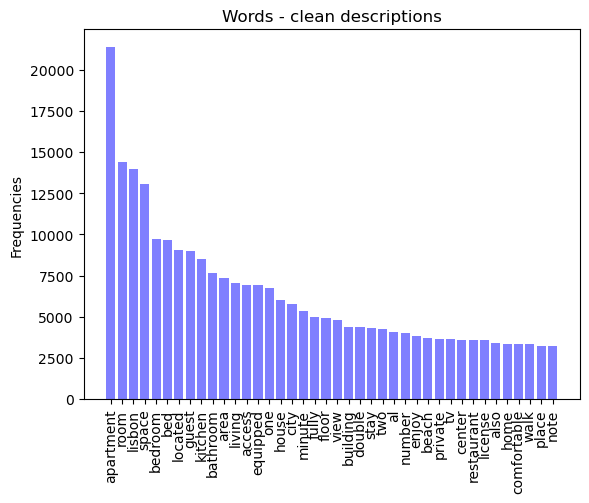

In [23]:
# Create a list with all words in train_df['cleaned_description']
all_words_desc_proc = ' '.join(train_df['cleaned_description']).split()

# The frequency of each word
freq_desc_proc = pd.Series(all_words_desc_proc).value_counts()

# A bar plot with the top 40 words, for 'host_about' column
x_labels = freq_desc_proc.index[0:40]
values = freq_desc_proc[:40]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'blue')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words - clean descriptions')
plt.xticks(rotation=90)
plt.show()

In [24]:
unique_words_desc_proc = sorted(set(all_words_desc_proc))
len(unique_words_desc_proc)

16387

In [146]:
len(all_words_desc)

1648726

<div class="alert alert-block alert-success">
Before the data preprocessing, we had 1,648,726 unique words after we reduced it to 16,387 words.

**host_about**

In [25]:
train_df['cleaned_host_about'] = clean(train_df['host_about_english'], lemmatize = True, stemmer = False)
train_df.head(3)

100%|██████████| 12496/12496 [00:35<00:00, 355.21it/s]


,df_index,description,host_about,unlisted,word_count_description,word_count_host_about,description_language,host_about_language,description_english,host_about_english,cleaned_description,cleaned_host_about
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127,4,en,pt,"This is a shared mixed room in our hostel, wit...",Local Accommodation Register: 20835/AL,shared mixed room hostel shared bathroom locat...,local accommodation register al
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23,24,pt,en,"My space is close to Parque Eduardo VII, Salda...","I am friendly host, and I will try to always b...",space close parque eduardo vii saldanha stefan...,friendly host try always around need anything ...
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170,45,en,en,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...


In [26]:
train_df.to_csv('output/train_cleaned.csv', index=False)

In [27]:
train_df.head()

,df_index,description,host_about,unlisted,word_count_description,word_count_host_about,description_language,host_about_language,description_english,host_about_english,cleaned_description,cleaned_host_about
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127,4,en,pt,"This is a shared mixed room in our hostel, wit...",Local Accommodation Register: 20835/AL,shared mixed room hostel shared bathroom locat...,local accommodation register al
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23,24,pt,en,"My space is close to Parque Eduardo VII, Salda...","I am friendly host, and I will try to always b...",space close parque eduardo vii saldanha stefan...,friendly host try always around need anything ...
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170,45,en,en,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!__ I m Portuguese and i love to meet peo...,0,47,31,pt,en,"Charming apartment in Chiado, Between the Farg...",Hello!__ I m Portuguese and i love to meet peo...,charming apartment chiado fargo carmo tripsa t...,hello portuguese love meet people around word ...
4,5,Joli appartement en bordure de mer. 2 min. a p...,Nous sommes une famille avec deux enfants de 1...,0,101,37,fr,fr,Jewelry apartment and sea coast. Two minutes. ...,We are a family with two children 17 and 10 ye...,jewelry apartment sea coast two minute foot be...,family two child year old lived portugal sever...


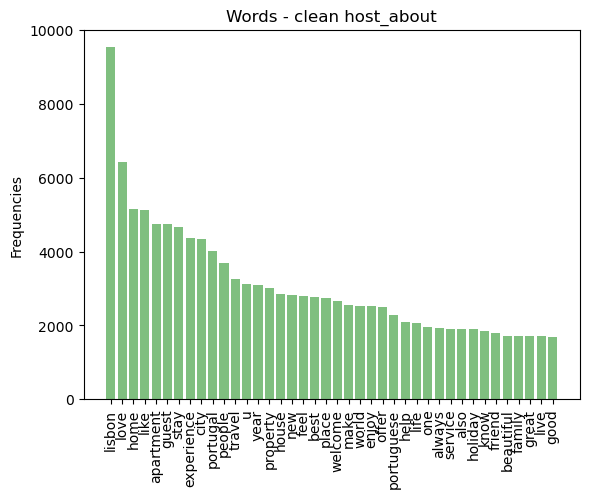

In [28]:
# create a list with all words in train_df['cleaned_host_about']
all_words_host_proc = ' '.join(train_df['cleaned_host_about']).split()

# The frequency of each word
freq_host_proc = pd.Series(all_words_host_proc).value_counts()

# A bar plot with the top 40 words, for 'host_about' column
x_labels = freq_host_proc.index[0:40]
values = freq_host_proc[:40]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'green')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words - clean host_about')
plt.xticks(rotation=90)
plt.show()

In [29]:
unique_words_host = sorted(set(all_words_host_proc))
len(unique_words_host)

11190

In [45]:
len(all_words_host)

931865

<div class="alert alert-block alert-success">
For hosts_about, before the data preprocessing, we had 931,865 unique words after we reduced it to 11,190 words.

**Comments**

In [30]:
review_df['cleaned_comments'] = clean(review_df['comments'], lemmatize = True, stemmer = False)
review_df.head(3)

100%|██████████| 721402/721402 [23:40<00:00, 507.95it/s]


,index,comments,word_count_comments,language,cleaned_comments
0,1,this is a very cozy and comfortable house to s...,28,en,cozy comfortable house stay never worry safety...
1,1,good<br/>,1,cy,good
2,1,"My first hostel experience, and all I have to ...",261,en,first hostel experience say pretty hard beat p...


In [31]:
review_df.to_csv('output/train_reviews_cleaned.csv', index=False)

In [32]:
review_df.head()

,index,comments,word_count_comments,language,cleaned_comments
0,1,this is a very cozy and comfortable house to s...,28,en,cozy comfortable house stay never worry safety...
1,1,good<br/>,1,cy,good
2,1,"My first hostel experience, and all I have to ...",261,en,first hostel experience say pretty hard beat p...
3,1,Das Hostel war neu und deshalb funktionierte a...,81,de,hostel war neu und deshalb funktionierte alles...
4,1,"It was fine for a dorm, but I think for the pe...",27,en,fine dorm think people staying far le bathroom...


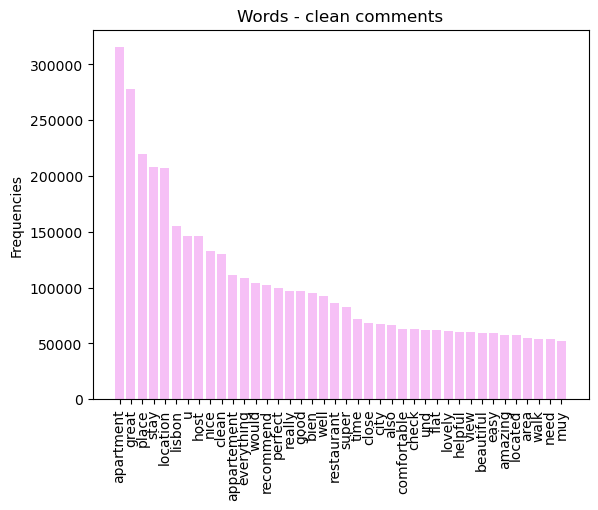

In [33]:
# Create a list with all words in review_df['cleaned_comments']
all_words_comments = ' '.join(review_df['cleaned_comments']).split()

# The frequency of each word
freq_comments = pd.Series(all_words_comments).value_counts()

# A bar plot with the top 40 words, for 'comments' column
x_labels = freq_comments.index[0:40]
values = freq_comments[:40]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'violet')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words - clean comments')
plt.xticks(rotation=90)
plt.show()

In [34]:
unique_words_comments = sorted(set(all_words_comments))
len(unique_words_comments)

169634

In [52]:
len(all_words_comments)

21570231

<div class="alert alert-block alert-success">
For comments, before the data preprocessing, we had 21,570,231 unique words after we reduced it to 169,634 words.

<hr>
<a class="anchor" id="prep_reviews">
    
## 3.4. Aggregating Reviews
    
</a>

In [42]:
reviews_df = pd.read_csv('output/train_reviews_cleaned.csv')

reviews_df['cleaned_comments'] = reviews_df['cleaned_comments'].astype('string')
reviews_df = reviews_df.dropna()

grouped = reviews_df.groupby(['index', 'language']).agg({'comments': 'count'})
grouped = grouped.reset_index()
final_grouped = grouped.groupby('index').agg({'language': 'nunique', 'comments': 'sum'})
final_grouped = final_grouped.reset_index()
final_grouped.columns = ['index', 'unique_languages_count', 'total_comments_count'] # rename the columns to the desired names


# Extracting and merging only English revies for now
reviews_df_eng = reviews_df[(reviews_df['language']=='en')]

grouped_eng = reviews_df_eng.groupby(['index']).agg({'comments': ['count', ' '.join]})
grouped_eng.columns = ['_'.join(col).strip() for col in grouped_eng.columns.values]
grouped_eng = grouped_eng.reset_index()

grouped_eng.columns = ['index', 'eng_comment_count', 'eng_reviews_merged'] # Rename the columns of the DataFrame

# Dataset constructed from Reviews
merged_reviews = pd.merge(final_grouped, grouped_eng, on='index', how='left')
merged_reviews.head()

,index,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged
0,1,6,46,29.0,this is a very cozy and comfortable house to s...
1,5,6,41,17.0,We really enjoyed staying at Sonias place. The...
2,8,5,164,145.0,Shani was very helpful throughout our process!...
3,9,6,32,16.0,Great little space; lovely hosts - clean and w...
4,10,3,13,11.0,"WOW, what a great stay! The spacious apartment..."


<hr>
<a class="anchor" id="training_features">
    
# 4. Feature Engineering
    
</a>

In [43]:
train_df = pd.read_csv('output/train_cleaned.csv')

train_df = pd.merge(train_df, merged_reviews, left_on='df_index', right_on = 'index', how='left').drop('index', axis =1)
train_df.rename(columns={'df_index': 'index'}, inplace=True)
train_df.head()

,index,description,host_about,unlisted,word_count_description,word_count_host_about,description_language,host_about_language,description_english,host_about_english,cleaned_description,cleaned_host_about,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127,4,en,pt,"This is a shared mixed room in our hostel, wit...",Local Accommodation Register: 20835/AL,shared mixed room hostel shared bathroom locat...,local accommodation register al,6.0,46.0,29.0,this is a very cozy and comfortable house to s...
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23,24,pt,en,"My space is close to Parque Eduardo VII, Salda...","I am friendly host, and I will try to always b...",space close parque eduardo vii saldanha stefan...,friendly host try always around need anything ...,NaN,NaN,NaN,NaN
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170,45,en,en,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,NaN,NaN,NaN,NaN
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!__ I m Portuguese and i love to meet peo...,0,47,31,pt,en,"Charming apartment in Chiado, Between the Farg...",Hello!__ I m Portuguese and i love to meet peo...,charming apartment chiado fargo carmo tripsa t...,hello portuguese love meet people around word ...,NaN,NaN,NaN,NaN
4,5,Joli appartement en bordure de mer. 2 min. a p...,Nous sommes une famille avec deux enfants de 1...,0,101,37,fr,fr,Jewelry apartment and sea coast. Two minutes. ...,We are a family with two children 17 and 10 ye...,jewelry apartment sea coast two minute foot be...,family two child year old lived portugal sever...,6.0,41.0,17.0,We really enjoyed staying at Sonias place. The...


In [44]:
# Checking for Missing Values
train_df.isna().sum()

index                        0
description                  0
host_about                  44
unlisted                     0
word_count_description       0
word_count_host_about        0
description_language         0
host_about_language        160
description_english          0
host_about_english          44
cleaned_description          0
cleaned_host_about          67
unique_languages_count    4032
total_comments_count      4032
eng_comment_count         4197
eng_reviews_merged        4197
dtype: int64

In [45]:
# Filling missing values with default ones
train_df['host_about'] = train_df['host_about'].fillna('Missing')
train_df['host_about_language'] = train_df['host_about_language'].fillna('en')
train_df['host_about_english'] = train_df['host_about_english'].fillna('Missing')
train_df['cleaned_host_about'] = train_df['cleaned_host_about'].fillna('Missing')
train_df['unique_languages_count'] = train_df['unique_languages_count'].fillna(0)
train_df['total_comments_count'] = train_df['total_comments_count'].fillna(0)
train_df['eng_comment_count'] = train_df['eng_comment_count'].fillna(0)
train_df['eng_reviews_merged'] = train_df['eng_reviews_merged'].fillna('Missing')

In [46]:
# Checking for Missing Values
train_df.isna().sum()

index                     0
description               0
host_about                0
unlisted                  0
word_count_description    0
word_count_host_about     0
description_language      0
host_about_language       0
description_english       0
host_about_english        0
cleaned_description       0
cleaned_host_about        0
unique_languages_count    0
total_comments_count      0
eng_comment_count         0
eng_reviews_merged        0
dtype: int64

<hr>
<a class="anchor" id="split">
    
## 4.1. Train / Validation Split
    
</a>

Split the dataset into train and validation and maintain the original format

In [47]:
train, validation =  train_test_split(train_df, test_size=0.2, random_state=42, 
                                    stratify=train_df['unlisted']) # using stratify, to keep classes proportion

print('Shapes of train:', train.shape)
print('Shapes of validation:', validation.shape)

Shapes of train: (9996, 16)
Shapes of validation: (2500, 16)


Define the independent variables:

In [48]:
x_train_1 = train['cleaned_description']
x_val_1 = validation['cleaned_description']

In [49]:
x_train_2 = train['cleaned_host_about']
x_val_2 = validation['cleaned_host_about']

In [50]:
x_train_3 = train['eng_reviews_merged']
x_val_3 = validation['eng_reviews_merged']

Define labels:

In [51]:
y_train = np.array(train['unlisted'])
len(y_train)

9996

In [52]:
y_val = np.array(validation['unlisted'])
len(y_val)

2500

<hr>
<a class="anchor" id="bow">
    
## 4.2. Bag of Words (BoW)
    
</a>

In [53]:
# With the binary Bag of Words, each word is a feature, with 1 and 0

Create BoW from train corpus:

In [54]:
bow_desc = CountVectorizer(binary=True)     
bow_host = CountVectorizer(binary=True)     
bow_reviews = CountVectorizer(binary=True) 

X_desc_bow = bow_desc.fit_transform(x_train_1)
X_host_bow = bow_host.fit_transform(x_train_2)
X_reviews_bow = bow_reviews.fit_transform(x_train_3)

print(X_desc_bow.shape, X_host_bow.shape, X_reviews_bow.shape)

(9996, 14979) (9996, 10508) (9996, 68219)


In [55]:
n1 = X_desc_bow.shape[1]
n2 = X_host_bow.shape[1]
n3 = X_reviews_bow.shape[1]

X_combined_bow = np.zeros((X_desc_bow.shape[0], n1 + n2 + n3))

X_combined_bow[:, :n1] = X_desc_bow.toarray() 
X_combined_bow[:, n1:n1+n2] = X_host_bow.toarray()
X_combined_bow[:, n1+n2:] = X_reviews_bow.toarray()

X_combined_bow.shape

(9996, 93706)

For validation:

In [56]:
X_desc_bow_val = bow_desc.transform(x_val_1)
X_host_bow_val = bow_host.transform(x_val_2)
X_reviews_bow_val = bow_reviews.transform(x_val_3)

print(X_desc_bow_val.shape, X_host_bow_val.shape, X_reviews_bow_val.shape)

(2500, 14979) (2500, 10508) (2500, 68219)


In [57]:
n1 = X_desc_bow_val.shape[1]
n2 = X_host_bow_val.shape[1]
n3 = X_reviews_bow_val.shape[1]

X_combined_bow_val = np.zeros((X_desc_bow_val.shape[0], n1 + n2 + n3))

X_combined_bow_val[:, :n1] = X_desc_bow_val.toarray() 
X_combined_bow_val[:, n1:n1+n2] = X_host_bow_val.toarray()
X_combined_bow_val[:, n1+n2:] = X_reviews_bow_val.toarray()                              

print(X_combined_bow_val.shape, y_val.shape)

(2500, 93706) (2500,)


<hr>
<a class="anchor" id="tf-idf">
    
## 4.3. TF_IDF
    
</a>

<hr>
<a class="anchor" id="1gram">
    
### 4.3.1.  1 Gram
    
</a>

In [58]:
# In BoW all the words have the same importance, 
# But the TF-IDF will penalize words that appear across too many documents 
# Should be a little more robuts than BoW

For Train Corpus:

In [59]:
tfidf_desc = TfidfVectorizer()
tfidf_host = TfidfVectorizer()
tfidf_reviews = TfidfVectorizer()

X_desc_tfidf = tfidf_desc.fit_transform(x_train_1)
X_host_tfidf = tfidf_host.fit_transform(x_train_2)
X_reviews_tfidf = tfidf_reviews.fit_transform(x_train_3)

print(X_desc_tfidf.shape, X_host_tfidf.shape, X_reviews_tfidf.shape)

(9996, 14979) (9996, 10508) (9996, 68219)


In [60]:
n1 = X_desc_tfidf.shape[1]
n2 = X_host_tfidf.shape[1]
n3 = X_reviews_tfidf.shape[1]

X_combined_tfidf = np.zeros((X_desc_tfidf.shape[0], n1 + n2 + n3))

X_combined_tfidf[:, :n1] = X_desc_tfidf.toarray() 
X_combined_tfidf[:, n1:n1+n2] = X_host_tfidf.toarray()
X_combined_tfidf[:, n1+n2:] = X_reviews_tfidf.toarray()

X_combined_tfidf.shape

(9996, 93706)

For Validation Corpus:

In [61]:
X_desc_tfidf_val = tfidf_desc.transform(x_val_1)
X_host_tfidf_val = tfidf_host.transform(x_val_2)
X_reviews_tfidf_val = tfidf_reviews.transform(x_val_3)

print(X_desc_tfidf_val.shape, X_host_tfidf_val.shape, X_reviews_tfidf_val.shape)

(2500, 14979) (2500, 10508) (2500, 68219)


In [62]:
n1 = X_desc_tfidf_val.shape[1]
n2 = X_host_tfidf_val.shape[1]
n3 = X_reviews_tfidf_val.shape[1]

X_combined_tfidf_val = np.zeros((X_desc_tfidf_val.shape[0], n1 + n2 + n3))

X_combined_tfidf_val[:, :n1] = X_desc_tfidf_val.toarray() 
X_combined_tfidf_val[:, n1:n1+n2] = X_host_tfidf_val.toarray()
X_combined_tfidf_val[:, n1+n2:] = X_reviews_tfidf_val.toarray()                              

print(X_combined_tfidf_val.shape, y_val.shape)

(2500, 93706) (2500,)


<hr>
<a class="anchor" id="12gram">
    
### 4.3.2.  1 and 2 Gram
    
</a>

For Train Corpus:

In [63]:
# Using ngram_range=(1, 2)
# to generate a feature matrix that includes single words as well as pairs of consecutive words, 
# capturing both the individual terms and some level of contextual information from the text.

tfidf_desc_2g = TfidfVectorizer(ngram_range=(1, 2), max_features = 15000)
tfidf_host_2g = TfidfVectorizer(ngram_range=(1, 2), max_features = 10000)
tfidf_reviews_2g = TfidfVectorizer(ngram_range=(1, 2), max_features = 68000)

X_desc_tfidf_2g = tfidf_desc_2g.fit_transform(x_train_1)
X_host_tfidf_2g = tfidf_host_2g.fit_transform(x_train_2)
X_reviews_tfidf_2g = tfidf_reviews_2g.fit_transform(x_train_3)

print(X_desc_tfidf_2g.shape, X_host_tfidf_2g.shape, X_reviews_tfidf_2g.shape)

(9996, 15000) (9996, 10000) (9996, 68000)


In [64]:
n1 = X_desc_tfidf_2g.shape[1]
n2 = X_host_tfidf_2g.shape[1]
n3 = X_reviews_tfidf_2g.shape[1]

X_combined_tfidf_2g = np.zeros((X_desc_tfidf_2g.shape[0], n1 + n2 + n3))

X_combined_tfidf_2g[:, :n1] = X_desc_tfidf_2g.toarray() 
X_combined_tfidf_2g[:, n1:n1+n2] = X_host_tfidf_2g.toarray()
X_combined_tfidf_2g[:, n1+n2:] = X_reviews_tfidf_2g.toarray()

X_combined_tfidf_2g.shape

(9996, 93000)

For Validation Corpus:

In [65]:
X_desc_tfidf_val_2g = tfidf_desc_2g.transform(x_val_1)
X_host_tfidf_val_2g = tfidf_host_2g.transform(x_val_2)
X_reviews_tfidf_val_2g = tfidf_reviews_2g.transform(x_val_3)

print(X_desc_tfidf_val_2g.shape, X_host_tfidf_val_2g.shape, X_reviews_tfidf_val_2g.shape)

(2500, 15000) (2500, 10000) (2500, 68000)


In [66]:
n1 = X_desc_tfidf_val_2g.shape[1]
n2 = X_host_tfidf_val_2g.shape[1]
n3 = X_reviews_tfidf_val_2g.shape[1]

X_combined_tfidf_val_2g = np.zeros((X_desc_tfidf_val_2g.shape[0], n1 + n2 + n3))

X_combined_tfidf_val_2g[:, :n1] = X_desc_tfidf_val_2g.toarray() 
X_combined_tfidf_val_2g[:, n1:n1+n2] = X_host_tfidf_val_2g.toarray()
X_combined_tfidf_val_2g[:, n1+n2:] = X_reviews_tfidf_val_2g.toarray()                              

print(X_combined_tfidf_val_2g.shape, y_val.shape)

(2500, 93000) (2500,)


<hr>
<a class="anchor" id="hashing">
    
## 4.4. Hashing Vectorizer
    
</a>

For Train Corpus:

In [67]:
hash_desc = HashingVectorizer(n_features = 1500)
hash_host = HashingVectorizer(n_features = 1000)
hash_reviews = HashingVectorizer(n_features = 6800)

X_desc_hash = hash_desc.fit_transform(x_train_1)
X_host_hash = hash_host.fit_transform(x_train_2)
X_reviews_hash = hash_reviews.fit_transform(x_train_3)

print(X_desc_hash.shape, X_host_hash.shape, X_reviews_hash.shape)

(9996, 1500) (9996, 1000) (9996, 6800)


In [68]:
n1 = X_desc_hash.shape[1]
n2 = X_host_hash.shape[1]
n3 = X_reviews_hash.shape[1]

X_combined_hash = np.zeros((X_desc_hash.shape[0], n1 + n2 + n3))

X_combined_hash[:, :n1] = X_desc_hash.toarray() 
X_combined_hash[:, n1:n1+n2] = X_host_hash.toarray()
X_combined_hash[:, n1+n2:] = X_reviews_hash.toarray()

X_combined_hash.shape

(9996, 9300)

For Validation Corpus:

In [69]:
X_desc_hash_val = hash_desc.transform(x_val_1)
X_host_hash_val = hash_host.transform(x_val_2)
X_reviews_hash_val = hash_reviews.transform(x_val_3)

print(X_desc_hash_val.shape, X_host_hash_val.shape, X_reviews_hash_val.shape)

(2500, 1500) (2500, 1000) (2500, 6800)


In [70]:
n1 = X_desc_hash_val.shape[1]
n2 = X_host_hash_val.shape[1]
n3 = X_reviews_hash_val.shape[1]

X_combined_hash_val = np.zeros((X_desc_hash_val.shape[0], n1 + n2 + n3))

X_combined_hash_val[:, :n1] = X_desc_hash_val.toarray() 
X_combined_hash_val[:, n1:n1+n2] = X_host_hash_val.toarray()
X_combined_hash_val[:, n1+n2:] = X_reviews_hash_val.toarray()                              

print(X_combined_hash_val.shape, y_val.shape)

(2500, 9300) (2500,)


<hr>
<a class="anchor" id="custom">
    
## 4.5. Custom Features
    
</a>

<hr>
<a class="anchor" id="custom_counts">
    
### 4.5.1. Feature Engineering based on Counting
    
</a>

In [71]:
train.head(3)

,index,description,host_about,unlisted,word_count_description,word_count_host_about,description_language,host_about_language,description_english,host_about_english,cleaned_description,cleaned_host_about,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged
7712,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,167,39,en,en,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,exclusive villa located quiet pinewood area co...,couple big family love travel nice welcome gue...,3.0,25.0,21.0,Great house in a great location. Close to Lisb...
11333,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,167,113,en,en,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",luna house part luna house hub located close v...,luna house part luna house hub located close v...,0.0,0.0,0.0,Missing
3536,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,175,21,en,en,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,newly refurbished apartment swimming pool stun...,world citizen looking forward meet new people ...,3.0,32.0,25.0,Great getaway in cascais. Gorgeous apartment a...


In [72]:
cols_to_take = ["index", "description", "word_count_description", "word_count_host_about", 
                "description_language", "host_about_language", "unique_languages_count", 
                "total_comments_count", "eng_comment_count"]

x_train_custom = train[cols_to_take]
x_train_custom['description_language'] = x_train_custom['description_language'].apply(lambda x: 1 if x == 'en' else 0)
x_train_custom['host_about_language'] = x_train_custom['host_about_language'].apply(lambda x: 1 if x == 'en' else 0)


x_val_custom = validation[cols_to_take]
x_val_custom['description_language'] = x_val_custom['description_language'].apply(lambda x: 1 if x == 'en' else 0)
x_val_custom['host_about_language'] = x_val_custom['host_about_language'].apply(lambda x: 1 if x == 'en' else 0)

In [73]:
x_train_custom.head(3)

,index,description,word_count_description,word_count_host_about,description_language,host_about_language,unique_languages_count,total_comments_count,eng_comment_count
7712,7713,"This exclusive villa, located in a quiet pinew...",167,39,1,1,3.0,25.0,21.0
11333,11334,"Luna House B&B is part of the Luna House Hub, ...",167,113,1,1,0.0,0.0,0.0
3536,3537,Newly refurbished apartment with swimming pool...,175,21,1,1,3.0,32.0,25.0


<hr>
<a class="anchor" id="custom_numeric">
    
### 4.5.2. Extracting Numeric Info from 'description'
    
</a>

In [74]:
# Defining functions to extract numeric information from 'description'
# based on regular expressions

word_to_number = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'seven': 7,
    'eight': 8,
    'nine': 9
}


def extract_room_numbers(text):
    room_pattern = r'\b(\d+|one|two|three|four|five|six|seven|eight|nine)\s*(?:-?\s*rooms?)\b'
    room_numbers = re.findall(room_pattern, text)
    if room_numbers:
        converted_numbers = []
        for number in room_numbers:
            if any(char.isdigit() for char in number):  # Check if the value contains a digit
                converted_numbers.append(int(number))
            else:
                converted_numbers.append(word_to_number.get(number, number))
        return max(converted_numbers)
    else:
        return np.nan
    
    
def extract_bedroom_numbers(text):
    room_pattern = r'\b(\d+|one|two|three|four|five|six|seven|eight|nine)\s*(?:-?\s*bedrooms?)\b'
    room_numbers = re.findall(room_pattern, text)
    if room_numbers:
        converted_numbers = []
        for number in room_numbers:
            if any(char.isdigit() for char in number):  # Check if the value contains a digit
                converted_numbers.append(int(number))
            else:
                converted_numbers.append(word_to_number.get(number, number))
        return max(converted_numbers)
    else:
        return np.nan
    
    
def extract_number_of_people(text):
    pattern = r'\b(\d+|one|two|three|four|five|six|seven|eight|nine)\s*(?:people?|guests?|persons?|friends?)\b'
    number_of_people = re.findall(pattern, text)
    if number_of_people:
        converted_numbers = []
        for number in number_of_people:
            if any(char.isdigit() for char in number):  # Check if the value contains a digit
                converted_numbers.append(int(number))
            else:
                converted_numbers.append(word_to_number.get(number, number))
        return max(converted_numbers)
    else:
        return np.nan
    
    
def extract_durations(text):
    time_pattern = r'\b(\d+|one|two|three|four|five|six|seven|eight|nine)\s*(?:-?\s*min|mins|minutes\b)'
    time_durations = re.findall(time_pattern, text)
    if time_durations:
        converted_numbers = []
        for number in time_durations:
            if any(char.isdigit() for char in number):  # Check if the value contains a digit
                converted_numbers.append(int(number))
            else:
                converted_numbers.append(word_to_number.get(number, number))
        average = sum(converted_numbers)/len(converted_numbers)
        return average
    else:
        return np.nan
        

def extract_license_numbers(text):
    # Regex pattern to match license numbers in the format: "digits/digitsAL"  
    license_pattern = r'\b(\d+)\/AL\b'
    license_number = re.findall(license_pattern, text)
    if license_number:
        return int(license_number[0])
    else:
        return np.nan
        
        
def extract_prices(text):
    euro_pattern = r'\b(\d+)\s*(?:euro(?:s)?|€)\b'
    prices = re.findall(euro_pattern, text)
    if prices:
        converted_numbers = []
        for number in prices:
            if any(char.isdigit() for char in number):  # Check if the value contains a digit
                converted_numbers.append(int(number))
            else:
                converted_numbers.append(word_to_number.get(number, number))
        average = sum(converted_numbers)/len(converted_numbers)
        return average
    else:
        return np.nan
    
    
def extract_prices(text):
    euro_pattern = r'\b(\d+)\s*(?:euro(?:s)?|€)\b'
    prices = re.findall(euro_pattern, text)
    if prices:
        converted_numbers = []
        for number in prices:
            if any(char.isdigit() for char in number):  # Check if the value contains a digit
                converted_numbers.append(int(number))
            else:
                converted_numbers.append(word_to_number.get(number, number))
        average = sum(converted_numbers)/len(converted_numbers)
        return average
    else:
        return np.nan

In [75]:
tqdm.pandas()

x_train_custom['capacity'] = x_train_custom['description'].progress_apply(lambda x: extract_number_of_people(x))
x_train_custom['time_durations'] = x_train_custom['description'].progress_apply(lambda x: extract_durations(x))
x_train_custom['rooms'] = x_train_custom['description'].progress_apply(lambda x: extract_room_numbers(x))
x_train_custom['bedrooms'] = x_train_custom['description'].progress_apply(lambda x: extract_bedroom_numbers(x))
x_train_custom['prices'] = x_train_custom['description'].progress_apply(lambda x: extract_prices(x))
x_train_custom['license'] = x_train_custom['description'].progress_apply(lambda x: extract_license_numbers(x))


x_val_custom['capacity'] = x_val_custom['description'].progress_apply(lambda x: extract_number_of_people(x))
x_val_custom['time_durations'] = x_val_custom['description'].progress_apply(lambda x: extract_durations(x))
x_val_custom['rooms'] = x_val_custom['description'].progress_apply(lambda x: extract_room_numbers(x))
x_val_custom['bedrooms'] = x_val_custom['description'].progress_apply(lambda x: extract_bedroom_numbers(x))
x_val_custom['prices'] = x_val_custom['description'].progress_apply(lambda x: extract_prices(x))
x_val_custom['license'] = x_val_custom['description'].progress_apply(lambda x: extract_license_numbers(x))

100%|████████████████████████████████████| 2500/2500 [00:00<00:00, 92408.35it/s]


In [76]:
# Checking custom features created so far for missing values
(x_train_custom.isnull().sum() / len(x_train_custom)) * 100

index                      0.000000
description                0.000000
word_count_description     0.000000
word_count_host_about      0.000000
description_language       0.000000
host_about_language        0.000000
unique_languages_count     0.000000
total_comments_count       0.000000
eng_comment_count          0.000000
capacity                  80.752301
time_durations            69.067627
rooms                     95.678271
bedrooms                  71.218487
prices                    98.929572
license                   70.718287
dtype: float64

In [77]:
# Filling in missing values with reasonable default values 

x_train_custom['capacity'].fillna(1, inplace=True)
x_train_custom['time_durations'].fillna(0, inplace=True)
x_train_custom['rooms'].fillna(1, inplace=True)
x_train_custom['bedrooms'].fillna(0, inplace=True)
x_train_custom['prices'].fillna(0, inplace=True)
x_train_custom['license'].fillna(0, inplace=True)
x_train_custom['total_rooms'] = np.maximum(x_train_custom['bedrooms'] + 1, x_train_custom['rooms'])
x_train_custom.drop(['description','rooms', 'bedrooms'], axis=1, inplace=True)


x_val_custom['capacity'].fillna(1, inplace=True)
x_val_custom['time_durations'].fillna(0, inplace=True)
x_val_custom['rooms'].fillna(1, inplace=True)
x_val_custom['bedrooms'].fillna(0, inplace=True)
x_val_custom['prices'].fillna(0, inplace=True)
x_val_custom['license'].fillna(0, inplace=True)
x_val_custom['total_rooms'] = np.maximum(x_val_custom['bedrooms'] + 1, x_val_custom['rooms'])
x_val_custom.drop(['description','rooms', 'bedrooms'], axis=1, inplace=True)


x_train_custom.head()

,index,word_count_description,word_count_host_about,description_language,host_about_language,unique_languages_count,total_comments_count,eng_comment_count,capacity,time_durations,prices,license,total_rooms
7712,7713,167,39,1,1,3.0,25.0,21.0,1.0,0.0,0.0,0.0,4.0
11333,11334,167,113,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
3536,3537,175,21,1,1,3.0,32.0,25.0,1.0,7.5,0.0,0.0,3.0
4061,4062,164,12,1,1,11.0,224.0,146.0,2.0,0.0,0.0,0.0,1.0
2742,2743,170,43,1,1,16.0,520.0,355.0,1.0,0.0,0.0,0.0,1.0


<hr>
<a class="anchor" id="custom_sentiment">
    
### 4.5.3. Sentiment Scores for Reviews
    
</a>

In [78]:
reviews_df = pd.read_csv('output/train_reviews_cleaned.csv')

#### (a) Analysing Sentiment with TextBlob

In [79]:
# Function to calculate the sentiment polarity using TextBlob 
# The polarity ranges from -1 to 1: -1 represents a negative sentiment, 0 is neutral, and 1 is positive

def get_sentiment_TextBlob(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    return sentiment

In [80]:
# Adding a new column with TextBlob Sentiment polarity

tqdm.pandas()
reviews_df['sentiment_TextBlob'] = reviews_df['comments'].progress_apply(get_sentiment_TextBlob) 

100%|█████████████████████████████████| 721402/721402 [01:43<00:00, 6967.65it/s]


#### (b) Analysing Sentiment with NLTK SentimentIntensityAnalyzer (vader_lexicon)

In [81]:
# Downloading "vader_lexicon" - 
# might need an unverified SSL context to allow downloading even if certificate verification fails
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/iryna/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [82]:
sid = SentimentIntensityAnalyzer() # Initialize the SentimentIntensityAnalyzer:

# Function to calculate the sentiment scores using the SentimentIntensityAnalyzer
# The compound score ranges from -1 to 1, 
# where -1 represents a highly negative sentiment, 0 is neutral, and 1 is highly positive.

def get_sentiment_nltk(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores['compound']

In [83]:
# Adding a new column with Polarity Scores from SentimentIntensityAnalyzer
tqdm.pandas()
reviews_df['sentiment_nltk'] = reviews_df['comments'].progress_apply(get_sentiment_nltk) 

100%|█████████████████████████████████| 721402/721402 [02:49<00:00, 4256.06it/s]


#### (c) Analysing Sentiment with tranformers (DistilBERT)

In [84]:
sentiment_analyzer = pipeline('sentiment-analysis')
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [85]:
# Define function to get Sentiment with the help of DistilBert sentiment_analyzer
def get_sentiment_distilbert(text):
    try:
        text = text.replace('<br/>', '')
        text = text.replace('_x000D_', '')
        result = sentiment_analyzer(text)[0]
        if result['label']=='POSITIVE':
            return result['score']
        elif result['label']=='NEGATIVE':
            return -(result['score'])
        else:
            return 0
    except: 
        return 0 # returning 0 as neutral score, when DistilBert sentiment analysis is failed 

In [ ]:
## TIME CONSUMING STEP
# Running this step took about 5 hours on MacBook Pro! 

comments_to_assess = reviews_df.comments
sentiment_distilbert = []

for i in tqdm(range(len(comments_to_assess))):
    new_sentiment = get_sentiment_distilbert(comments_to_assess[i])
    sentiment_distilbert.append(new_sentiment)
    
    
# Add a new column to train_df
reviews_df['sentiment_distilbert'] = sentiment_distilbert
reviews_df.to_csv('output/train_reviews_with_sentiment.csv', index=False)

<hr>
<a class="anchor" id="custom_merge">
    
### 4.5.4. Merging and Scaling Custom Features 
    
</a>

In [86]:
reviews_df = pd.read_csv('output/train_reviews_with_sentiment.csv')
reviews_df.head()

,index,comments,word_count_comments,language,cleaned_comments,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,this is a very cozy and comfortable house to s...,28,en,cozy comfortable house stay never worry safety...,0.113333,0.5367,0.999756
1,1,good<br/>,1,cy,good br,0.000000,0.0000,0.999816
2,1,"My first hostel experience, and all I have to ...",261,en,first hostel experience say pretty hard beat p...,0.269540,0.9832,0.973215
3,1,Das Hostel war neu und deshalb funktionierte a...,81,de,da hostel war neu und deshalb funktionierte al...,0.781250,-0.8920,-0.992741
4,1,"It was fine for a dorm, but I think for the pe...",27,en,fine dorm think people staying far le bathroom...,0.116667,0.1027,-0.998398


In [87]:
# Group by 'index' and calculate average number of words in review
grouped_count_words = reviews_df.groupby('index')['word_count_comments'].mean().reset_index()
grouped_count_words.head()

,index,word_count_comments
0,1,26.620000
1,5,25.951220
2,8,47.291667
3,9,40.121212
4,10,61.615385


In [88]:
# Group by 'index' and calculate average values for sentiments
grouped_sentiment = reviews_df.groupby('index')[
    ['sentiment_TextBlob', 'sentiment_nltk', 'sentiment_distilbert']].mean().reset_index()

grouped_sentiment.head()

,index,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,0.286502,0.357148,0.395436
1,5,0.288274,0.354554,0.019208
2,8,0.421883,0.805188,0.811892
3,9,0.264353,0.381127,0.213370
4,10,0.319647,0.574915,0.385108


In [89]:
reviews_aggregated = pd.merge(grouped_count_words, grouped_sentiment, on='index', how='left')
reviews_aggregated.head()

,index,word_count_comments,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,26.620000,0.286502,0.357148,0.395436
1,5,25.951220,0.288274,0.354554,0.019208
2,8,47.291667,0.421883,0.805188,0.811892
3,9,40.121212,0.264353,0.381127,0.213370
4,10,61.615385,0.319647,0.574915,0.385108


In [90]:
x_train_custom = pd.merge(x_train_custom, reviews_aggregated, on='index', how='left')
x_train_custom.drop(['index'], axis=1, inplace=True)
x_train_custom.fillna(0, inplace=True)

x_train_custom.head()

,word_count_description,word_count_host_about,description_language,host_about_language,unique_languages_count,total_comments_count,eng_comment_count,capacity,time_durations,prices,license,total_rooms,word_count_comments,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,167,39,1,1,3.0,25.0,21.0,1.0,0.0,0.0,0.0,4.0,73.400000,0.403832,0.777068,0.766709
1,167,113,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000
2,175,21,1,1,3.0,32.0,25.0,1.0,7.5,0.0,0.0,3.0,56.424242,0.354318,0.706224,0.657368
3,164,12,1,1,11.0,224.0,146.0,2.0,0.0,0.0,0.0,1.0,33.154867,0.328994,0.533196,0.544072
4,170,43,1,1,16.0,520.0,355.0,1.0,0.0,0.0,0.0,1.0,48.468451,0.343260,0.609638,0.589948


In [91]:
x_train_custom.shape

(9996, 16)

In [92]:
x_val_custom = pd.merge(x_val_custom, reviews_aggregated, on='index', how='left')
x_val_custom.drop(['index'], axis=1, inplace=True)
x_val_custom.fillna(0, inplace=True)

x_val_custom.head()

,word_count_description,word_count_host_about,description_language,host_about_language,unique_languages_count,total_comments_count,eng_comment_count,capacity,time_durations,prices,license,total_rooms,word_count_comments,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,155,14,1,1,8.0,54.0,33.0,6.0,3.5,0.0,60424.0,1.0,34.611111,0.366252,0.582431,0.439126
1,165,58,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000
2,170,254,1,1,9.0,139.0,105.0,1.0,0.0,0.0,0.0,1.0,37.546099,0.349032,0.615323,0.609855
3,166,148,1,1,11.0,207.0,144.0,1.0,0.0,0.0,0.0,5.0,46.004808,0.388054,0.618891,0.573898
4,160,110,1,1,8.0,33.0,22.0,1.0,0.0,0.0,0.0,3.0,37.676471,0.274337,0.476368,0.298620


In [93]:
x_val_custom.shape

(2500, 16)

In [94]:
# Scaling Features
cols_to_scale = ['word_count_description', 'word_count_host_about', 'unique_languages_count', 
                 'total_comments_count','eng_comment_count', 'capacity', 'time_durations', 
                 'prices', 'license', 'total_rooms', 'word_count_comments']

scaler = StandardScaler()

x_train_custom[cols_to_scale] = scaler.fit_transform(x_train_custom[cols_to_scale])
x_val_custom[cols_to_scale] = scaler.transform(x_val_custom[cols_to_scale])

In [74]:
# Storing Custom Features
x_train_custom.to_csv('output/x_train_custom.csv', index=False)
x_val_custom.to_csv('output/x_val_custom.csv', index=False)

In [95]:
x_train_custom = pd.read_csv('output/x_train_custom.csv')
x_val_custom = pd.read_csv('output/x_val_custom.csv')

<hr>
<a class="anchor" id="classificationmodels">
    
# 5. Classification Models
    
</a>

In [96]:
labels = {"Unlisted":1, "Listed":0}

In [97]:
# Function to assess the model prediction performance

def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    #plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    #plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

<hr>
<a class="anchor" id="KNN">
    
## 5.1. KNeighborsClassifier
    
</a>

In [98]:
modelknn = KNeighborsClassifier(n_neighbors = 7, metric = 'cosine', weights = 'distance')

<hr>
<a class="anchor" id="KNN_bow">
    
### 5.1.1. Bow
    
</a>

Based on **description**:

              precision    recall  f1-score   support

    Unlisted       0.90      0.81      0.85      2028
      Listed       0.43      0.63      0.51       472

    accuracy                           0.77      2500
   macro avg       0.67      0.72      0.68      2500
weighted avg       0.81      0.77      0.79      2500



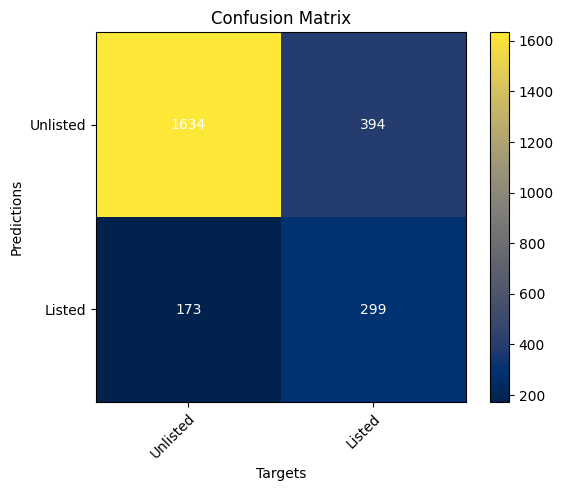

In [99]:
modelknn.fit(X_desc_bow,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_desc_bow_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **host_about**:

              precision    recall  f1-score   support

    Unlisted       0.88      0.83      0.85      1934
      Listed       0.51      0.63      0.56       566

    accuracy                           0.78      2500
   macro avg       0.70      0.73      0.71      2500
weighted avg       0.80      0.78      0.79      2500



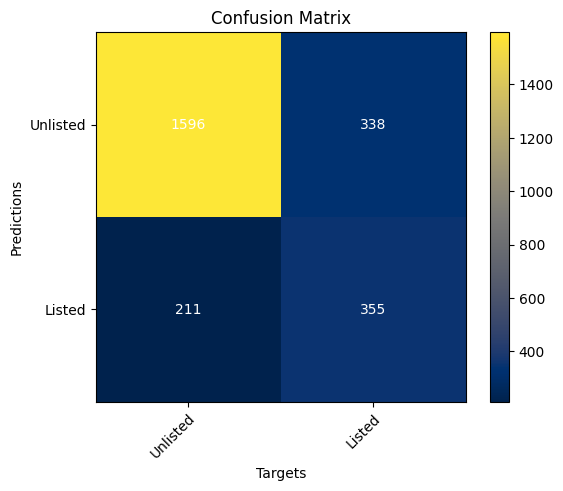

In [80]:
modelknn.fit(X_host_bow,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_host_bow_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **comments**:

              precision    recall  f1-score   support

    Unlisted       0.85      0.93      0.89      1656
      Listed       0.83      0.68      0.75       844

    accuracy                           0.85      2500
   macro avg       0.84      0.81      0.82      2500
weighted avg       0.84      0.85      0.84      2500



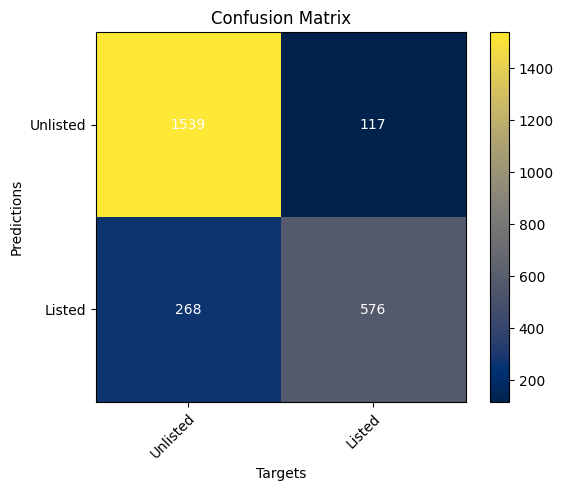

In [100]:
modelknn.fit(X_reviews_bow,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_reviews_bow_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.93      0.91      0.92      1831
      Listed       0.77      0.80      0.79       669

    accuracy                           0.88      2500
   macro avg       0.85      0.86      0.85      2500
weighted avg       0.89      0.88      0.88      2500



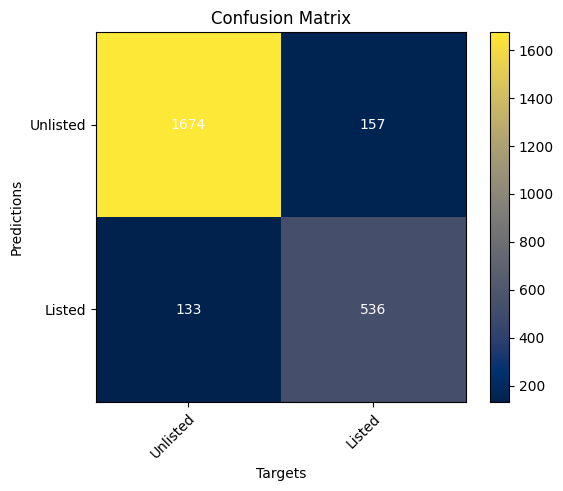

In [101]:
modelknn.fit(X_combined_bow,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_combined_bow_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

<hr>
<a class="anchor" id="KNN_tfidf-1gram">
    
### 5.1.2. TF-IDF (1-Gram)
    
</a>

Based on **description**:

              precision    recall  f1-score   support

    Unlisted       0.92      0.81      0.86      2036
      Listed       0.45      0.67      0.54       464

    accuracy                           0.79      2500
   macro avg       0.68      0.74      0.70      2500
weighted avg       0.83      0.79      0.80      2500



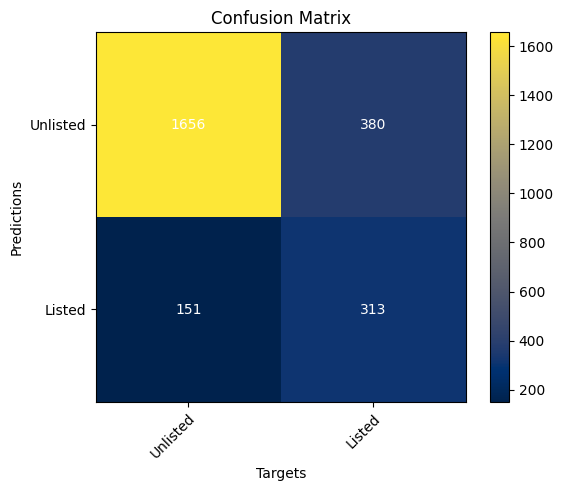

In [102]:
modelknn.fit(X_desc_tfidf,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_desc_tfidf_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **host_about**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.82      0.86      2002
      Listed       0.48      0.67      0.56       498

    accuracy                           0.79      2500
   macro avg       0.70      0.75      0.71      2500
weighted avg       0.82      0.79      0.80      2500



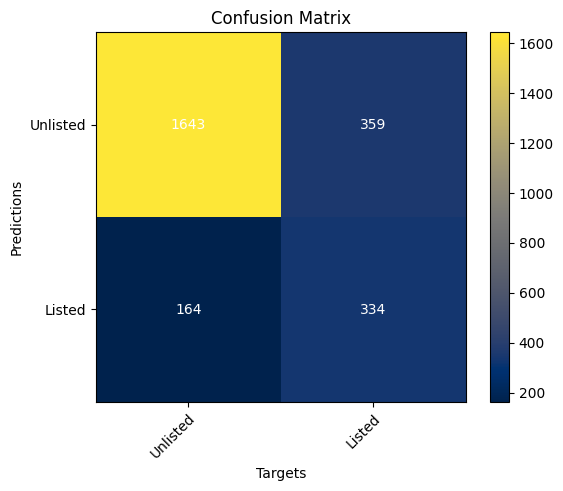

In [103]:
modelknn.fit(X_host_tfidf,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_host_tfidf_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **comments**:

              precision    recall  f1-score   support

    Unlisted       1.00      0.72      0.84      2488
      Listed       0.01      0.42      0.01        12

    accuracy                           0.72      2500
   macro avg       0.50      0.57      0.43      2500
weighted avg       0.99      0.72      0.83      2500



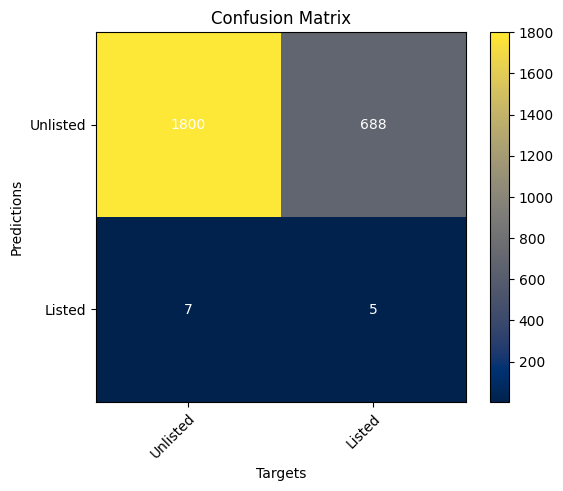

In [104]:
modelknn.fit(X_reviews_tfidf,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_reviews_tfidf_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.93      0.91      0.92      1843
      Listed       0.76      0.81      0.79       657

    accuracy                           0.88      2500
   macro avg       0.85      0.86      0.85      2500
weighted avg       0.89      0.88      0.88      2500



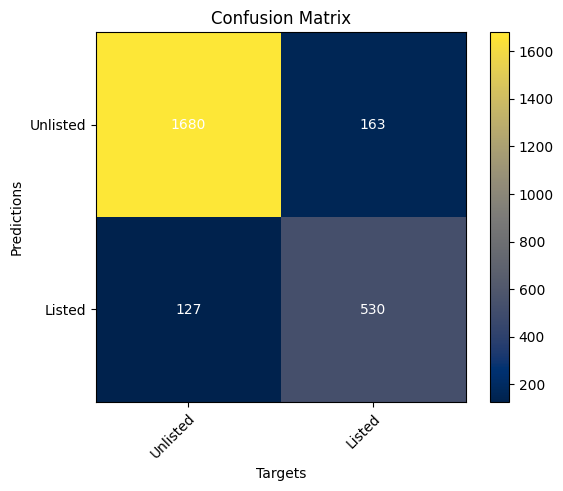

In [105]:
modelknn.fit(X_combined_tfidf,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_combined_tfidf_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

<hr>
<a class="anchor" id="KNN_tfidf-2gram">
    
### 5.1.3. TF-IDF (2-Gram)
    
</a>

Based on **description**:

              precision    recall  f1-score   support

    Unlisted       0.93      0.81      0.87      2069
      Listed       0.44      0.70      0.54       431

    accuracy                           0.79      2500
   macro avg       0.68      0.76      0.70      2500
weighted avg       0.84      0.79      0.81      2500



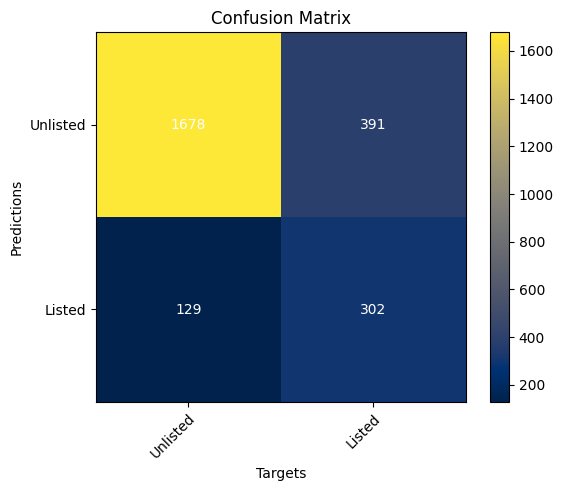

In [106]:
modelknn.fit(X_desc_tfidf_2g,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_desc_tfidf_val_2g)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **host_about**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.82      0.86      1994
      Listed       0.49      0.67      0.57       506

    accuracy                           0.79      2500
   macro avg       0.70      0.75      0.71      2500
weighted avg       0.82      0.79      0.80      2500



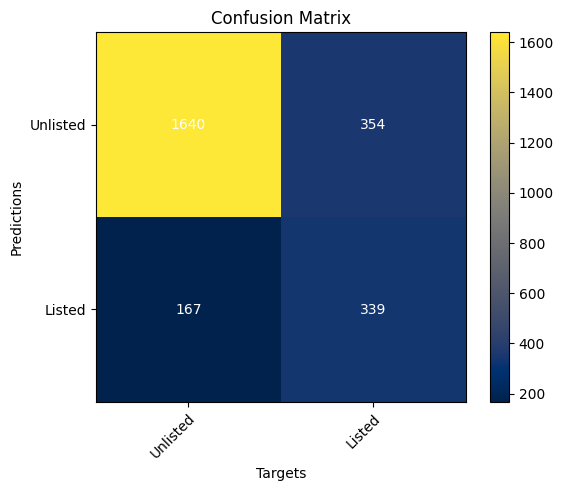

In [107]:
modelknn.fit(X_host_tfidf_2g,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_host_tfidf_val_2g)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **comments**:

              precision    recall  f1-score   support

    Unlisted       1.00      0.72      0.84      2498
      Listed       0.00      0.00      0.00         2

    accuracy                           0.72      2500
   macro avg       0.50      0.36      0.42      2500
weighted avg       1.00      0.72      0.84      2500



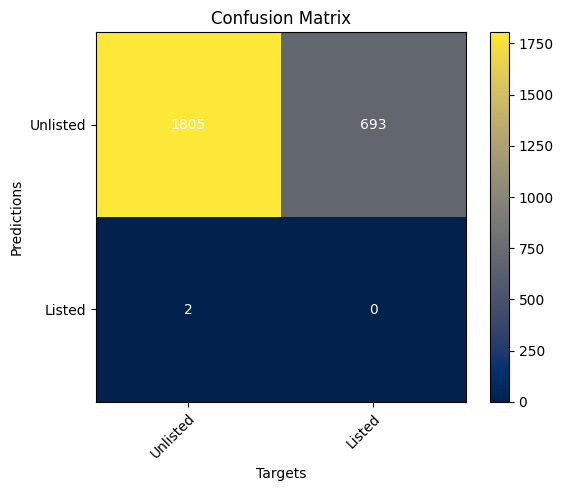

In [108]:
modelknn.fit(X_reviews_tfidf_2g,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_reviews_tfidf_val_2g)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **description and comments**:

              precision    recall  f1-score   support

    Unlisted       0.93      0.91      0.92      1836
      Listed       0.77      0.80      0.78       664

    accuracy                           0.88      2500
   macro avg       0.85      0.86      0.85      2500
weighted avg       0.88      0.88      0.88      2500



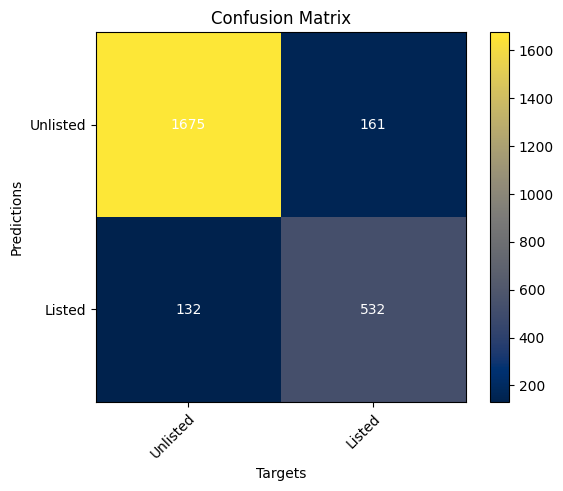

In [109]:
modelknn.fit(X_combined_tfidf_2g,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_combined_tfidf_val_2g)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

<hr>
<a class="anchor" id="KNN-hash">
    
### 5.1.4. Hashing Vectorizer
    
</a>

Based on **description**:

              precision    recall  f1-score   support

    Unlisted       0.92      0.80      0.86      2062
      Listed       0.42      0.66      0.51       438

    accuracy                           0.78      2500
   macro avg       0.67      0.73      0.69      2500
weighted avg       0.83      0.78      0.80      2500



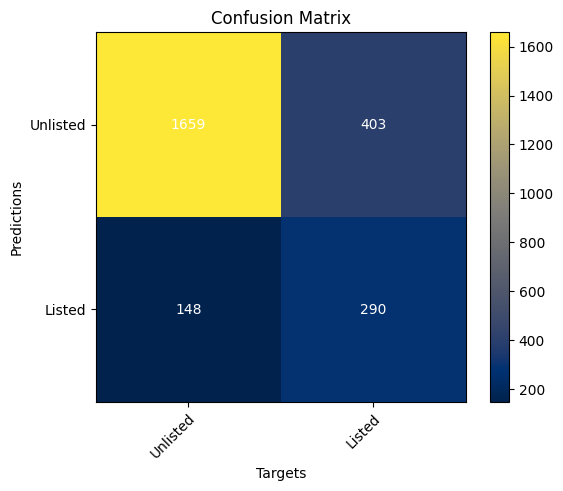

In [110]:
modelknn.fit(X_desc_hash,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_desc_hash_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **host_about**:

              precision    recall  f1-score   support

    Unlisted       0.90      0.82      0.86      1996
      Listed       0.47      0.65      0.54       504

    accuracy                           0.78      2500
   macro avg       0.69      0.73      0.70      2500
weighted avg       0.81      0.78      0.79      2500



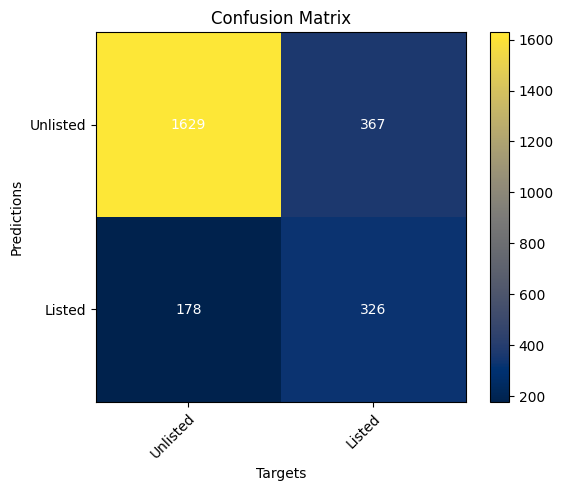

In [111]:
modelknn.fit(X_host_hash,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_host_hash_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **comments**:

              precision    recall  f1-score   support

    Unlisted       0.85      0.93      0.89      1653
      Listed       0.83      0.68      0.75       847

    accuracy                           0.84      2500
   macro avg       0.84      0.80      0.82      2500
weighted avg       0.84      0.84      0.84      2500



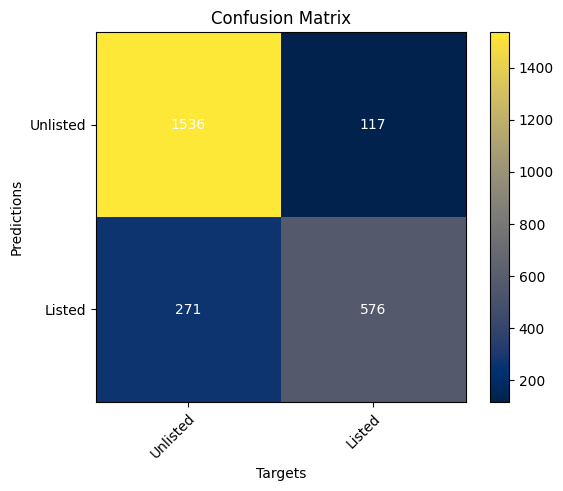

In [112]:
modelknn.fit(X_reviews_hash,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_reviews_hash_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.93      0.91      0.92      1840
      Listed       0.77      0.81      0.79       660

    accuracy                           0.89      2500
   macro avg       0.85      0.86      0.86      2500
weighted avg       0.89      0.89      0.89      2500



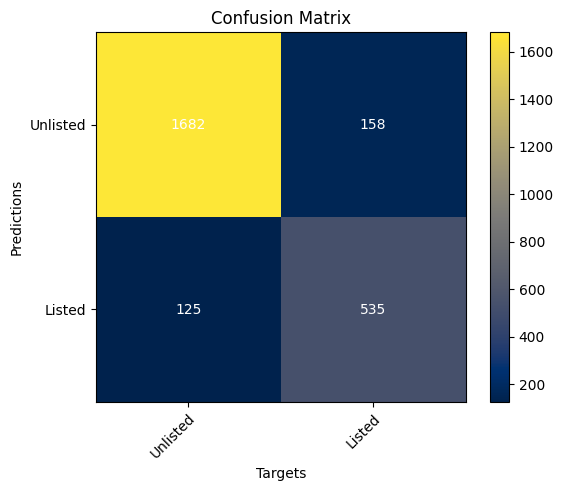

In [113]:
modelknn.fit(X_combined_hash,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_combined_hash_val)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

<hr>
<a class="anchor" id="KNN-custom">
    
### 5.1.5. Custom Features
    
</a>

              precision    recall  f1-score   support

    Unlisted       0.92      0.89      0.91      1870
      Listed       0.71      0.78      0.74       630

    accuracy                           0.86      2500
   macro avg       0.82      0.84      0.82      2500
weighted avg       0.87      0.86      0.87      2500



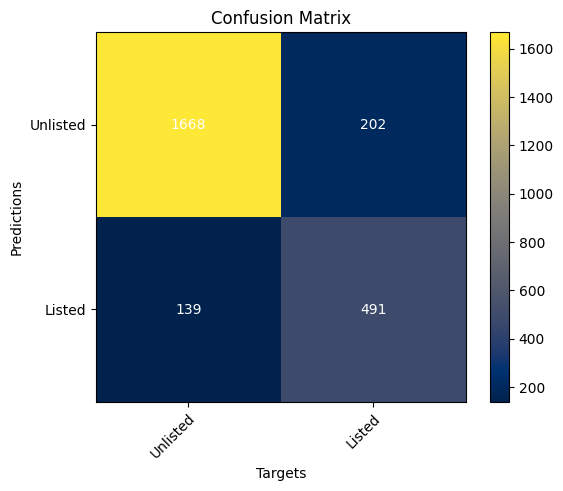

In [114]:
modelknn.fit(x_train_custom, y_train)

# Prediction
y_pred_knn = modelknn.predict(x_val_custom)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

<hr>
<a class="anchor" id="randomforest">
    
## 5.2. Random Forest
    
</a>

In [115]:
model_forest = RandomForestClassifier(n_estimators=50, 
                                      class_weight={0: 0.7, 1: 0.3}, 
                                      random_state=42)

<hr>
<a class="anchor" id="randomforest_bow">
    
### 5.2.1. BoW
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.93      0.92      1775
      Listed       0.82      0.78      0.80       725

    accuracy                           0.89      2500
   macro avg       0.87      0.86      0.86      2500
weighted avg       0.89      0.89      0.89      2500



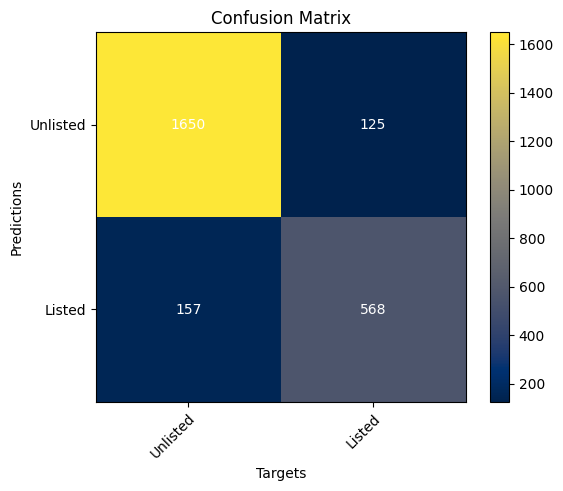

In [116]:
model_forest.fit(X_combined_bow,y_train)

# Prediction
y_pred_forest = model_forest.predict(X_combined_bow_val)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

<hr>
<a class="anchor" id="randomforest_tfidf-1gram">
    
### 5.2.2. TF-IDF (1-Gram)
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.93      0.92      1775
      Listed       0.82      0.78      0.80       725

    accuracy                           0.89      2500
   macro avg       0.87      0.86      0.86      2500
weighted avg       0.89      0.89      0.89      2500



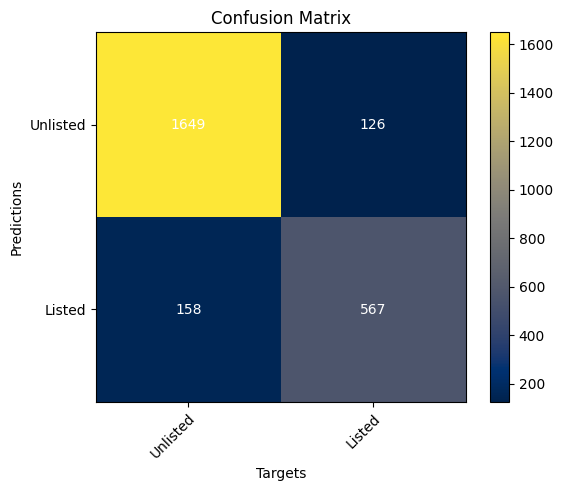

In [117]:
model_forest.fit(X_combined_tfidf,y_train)

# Prediction
y_pred_forest = model_forest.predict(X_combined_tfidf_val)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

<hr>
<a class="anchor" id="randomforest_tfidf-2gram">
    
### 5.2.3. TF-IDF (2-Gram)
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.93      0.92      1783
      Listed       0.81      0.78      0.80       717

    accuracy                           0.89      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.88      0.89      0.89      2500



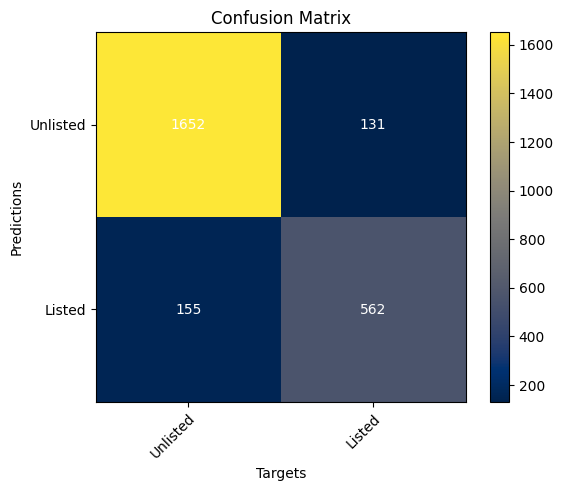

In [118]:
model_forest.fit(X_combined_tfidf_2g,y_train)

# Prediction
y_pred_forest = model_forest.predict(X_combined_tfidf_val_2g)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

<hr>
<a class="anchor" id="randomforest_hash">
    
### 5.2.4. Hashing Vectorizer
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.92      0.92      1791
      Listed       0.80      0.78      0.79       709

    accuracy                           0.88      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.88      0.88      0.88      2500



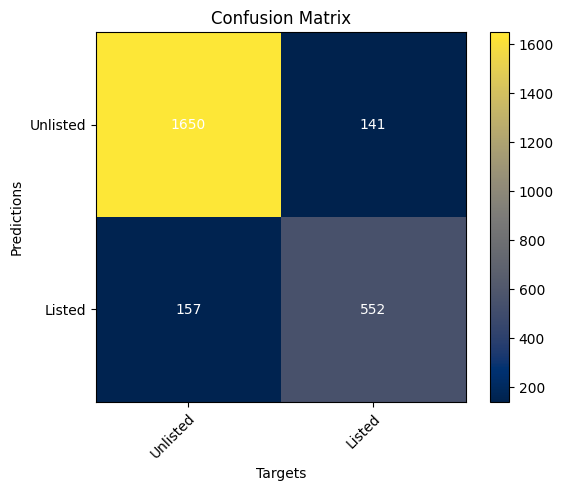

In [119]:
model_forest.fit(X_combined_hash, y_train)

# Prediction
y_pred_forest = model_forest.predict(X_combined_hash_val)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

<hr>
<a class="anchor" id="randomforest_custom">
    
### 5.2.5. Custom Features
    
</a>

              precision    recall  f1-score   support

    Unlisted       0.91      0.92      0.92      1791
      Listed       0.80      0.78      0.79       709

    accuracy                           0.88      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.88      0.88      0.88      2500



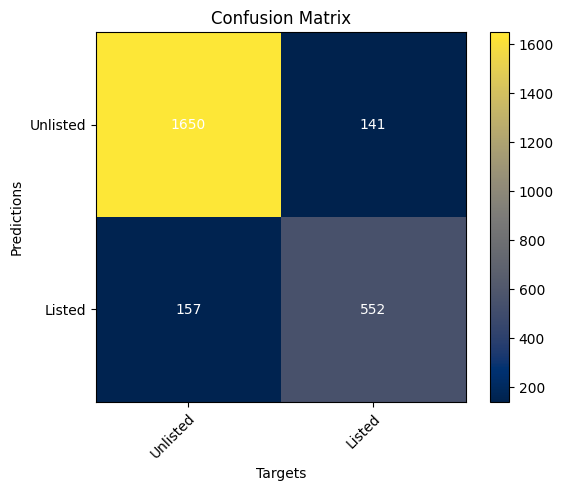

In [120]:
model_forest.fit(x_train_custom, y_train)

# Prediction
y_pred_knn = model_forest.predict(x_val_custom)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

<hr>
<a class="anchor" id="logisticregression">
    
## 5.3. Logistic Regression
    
</a>

In [121]:
model_lr = LogisticRegression(solver = 'liblinear')

<hr>
<a class="anchor" id="lr_bow">
    
### 5.3.1 BoW
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.92      0.91      0.91      1830
      Listed       0.76      0.78      0.77       670

    accuracy                           0.87      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.88      0.87      0.87      2500



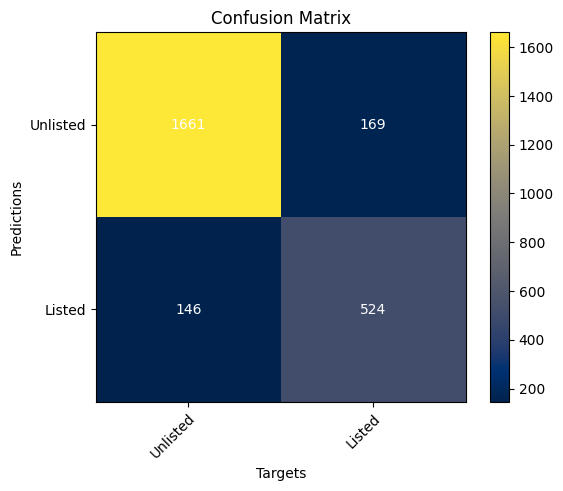

In [122]:
model_lr.fit(X_combined_bow, y_train)

# Predicting
y_pred_lr = model_lr.predict(X_combined_bow_val)

# Evaluation
print(classification_report(y_pred_lr, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_lr, y_val), labels.keys())

<hr>
<a class="anchor" id="log_1gram">
    
### 5.3.2. TF-IDF (1-Gram)
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.93      0.92      1763
      Listed       0.82      0.77      0.80       737

    accuracy                           0.88      2500
   macro avg       0.86      0.85      0.86      2500
weighted avg       0.88      0.88      0.88      2500



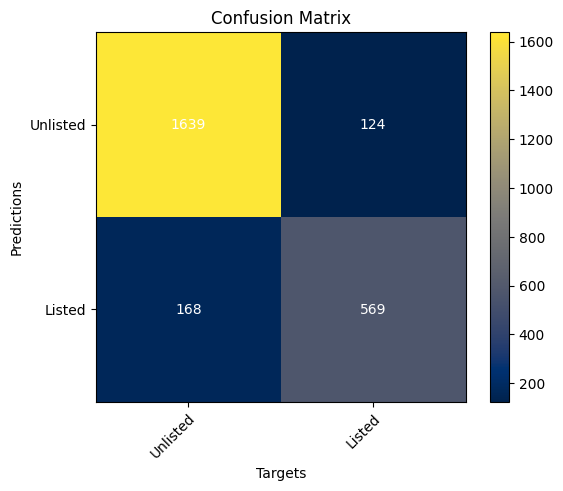

In [123]:
model_lr.fit(X_combined_tfidf, y_train)

# Predicting
y_pred_lr = model_lr.predict(X_combined_tfidf_val)

# Evaluation
print(classification_report(y_pred_lr, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_lr, y_val), labels.keys())

<hr>
<a class="anchor" id="log_2gram">
    
### 5.3.3. TF-IDF (2-Gram)
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.93      0.92      1761
      Listed       0.82      0.77      0.80       739

    accuracy                           0.88      2500
   macro avg       0.87      0.85      0.86      2500
weighted avg       0.88      0.88      0.88      2500



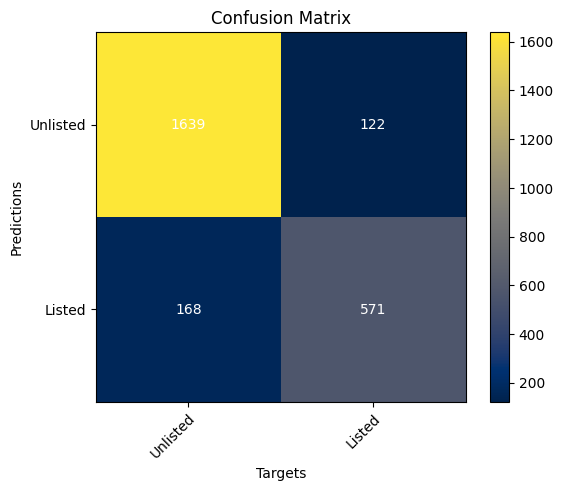

In [124]:
model_lr.fit(X_combined_tfidf_2g, y_train)

# Predicting
y_pred_lr = model_lr.predict(X_combined_tfidf_val_2g)

# Evaluation
print(classification_report(y_pred_lr, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_lr, y_val), labels.keys())

<hr>
<a class="anchor" id="log_hash">
    
### 5.3.4. Hashing Vectorizer
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.89      0.92      0.91      1760
      Listed       0.79      0.74      0.77       740

    accuracy                           0.87      2500
   macro avg       0.84      0.83      0.84      2500
weighted avg       0.86      0.87      0.87      2500



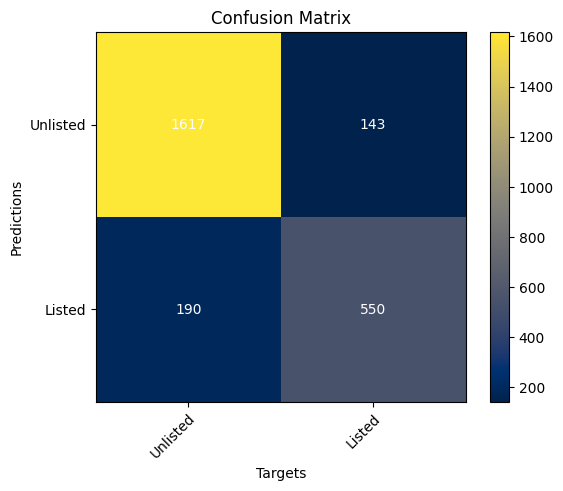

In [125]:
model_lr.fit(X_combined_hash, y_train)

# Predicting
y_pred_lr = model_lr.predict(X_combined_hash_val)

# Evaluation
print(classification_report(y_pred_lr, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_lr, y_val), labels.keys())

<hr>
<a class="anchor" id="log_custom">
    
### 5.3.5. Custom Features
    
</a>

              precision    recall  f1-score   support

    Unlisted       0.86      0.93      0.90      1681
      Listed       0.83      0.70      0.76       819

    accuracy                           0.85      2500
   macro avg       0.85      0.81      0.83      2500
weighted avg       0.85      0.85      0.85      2500



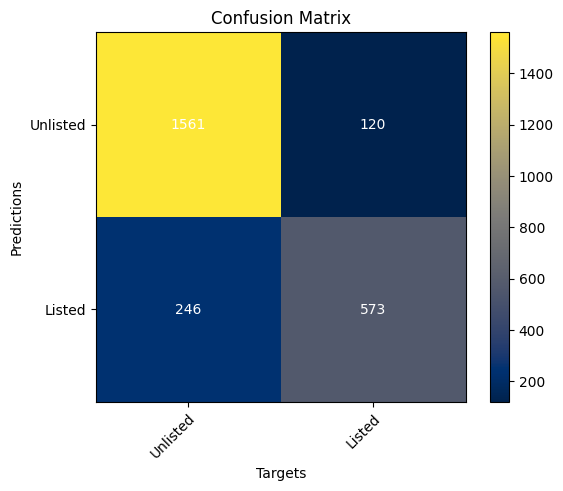

In [126]:
model_lr.fit(x_train_custom, y_train)

# Predicting
y_pred_lr = model_lr.predict(x_val_custom)

# Evaluation
print(classification_report(y_pred_lr, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_lr, y_val), labels.keys())

<hr>
<a class="anchor" id="nn">
    
## 5.4. Neural Networks
    
</a>

In [127]:
model_nn = MLPClassifier(solver='sgd', learning_rate_init = 0.001 , activation='relu', random_state=1)

<hr>
<a class="anchor" id="nn_bow">
    
### 5.4.1 BoW
    
</a>

Based on **description, host_about and comments**:

In [ ]:
model_nn.fit(X_combined_bow, y_train)

# Predicting
y_pred_nn = model_nn.predict(X_combined_bow_val)

# Evaluation
print(classification_report(y_pred_nn, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_nn, y_val), labels.keys())

<hr>
<a class="anchor" id="nn_1gram">
    
### 5.4.2. TF-IDF (1-Gram)
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.86      0.93      0.89      1673
      Listed       0.83      0.70      0.76       827

    accuracy                           0.85      2500
   macro avg       0.85      0.81      0.83      2500
weighted avg       0.85      0.85      0.85      2500



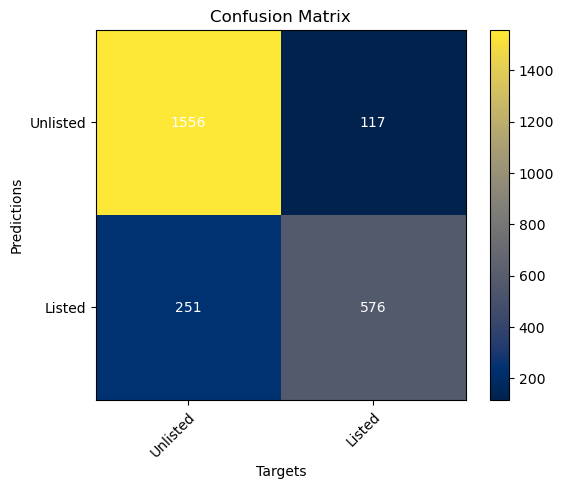

In [51]:
model_nn.fit(X_combined_tfidf, y_train)

# Predicting
y_pred_nn = model_nn.predict(X_combined_tfidf_val)

# Evaluation
print(classification_report(y_pred_nn, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_nn, y_val), labels.keys())

<hr>
<a class="anchor" id="nn_2gram">
    
### 5.4.3. TF-IDF (2-Gram)
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.86      0.93      0.89      1673
      Listed       0.83      0.70      0.76       827

    accuracy                           0.85      2500
   macro avg       0.85      0.81      0.83      2500
weighted avg       0.85      0.85      0.85      2500



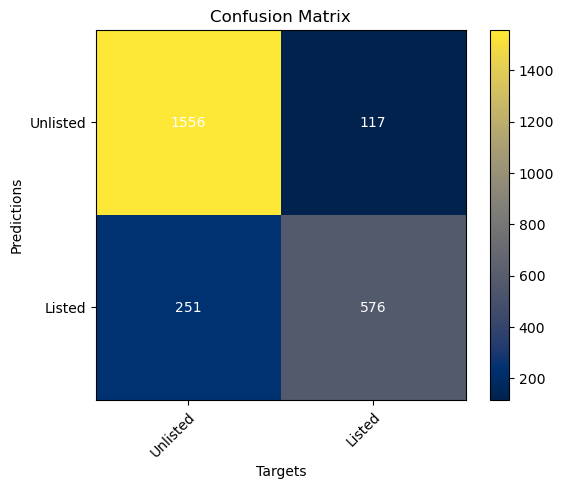

In [52]:
model_nn.fit(X_combined_tfidf_2g, y_train)

# Predicting
y_pred_nn = model_nn.predict(X_combined_tfidf_val_2g)

# Evaluation
print(classification_report(y_pred_nn, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_nn, y_val), labels.keys())

<hr>
<a class="anchor" id="nn_hash">
    
### 5.4.4. Hashing Vectorizer
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.86      0.93      0.89      1672
      Listed       0.83      0.70      0.76       828

    accuracy                           0.85      2500
   macro avg       0.85      0.81      0.83      2500
weighted avg       0.85      0.85      0.85      2500



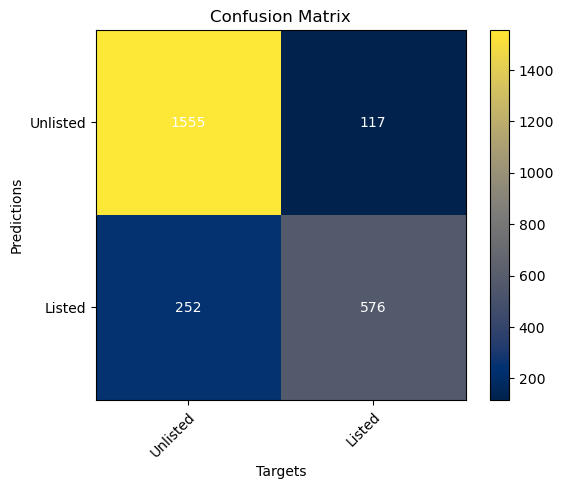

In [53]:
model_nn.fit(X_combined_hash, y_train)

# Predicting
y_pred_nn = model_nn.predict(X_combined_hash_val)

# Evaluation
print(classification_report(y_pred_nn, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_nn, y_val), labels.keys())

<hr>
<a class="anchor" id="nn_custom">
    
### 5.4.5. Custom Features
    
</a>

In [ ]:
model_nn.fit(x_train_custom, y_train)

# Predicting
y_pred_nn = model_nn.predict(x_val_custom)

# Evaluation
print(classification_report(y_pred_nn, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_nn, y_val), labels.keys())

<hr>
<a class="anchor" id="xgboost">
    
## 5.5. XGBoost model
    
</a>

In [54]:
model_xgb = xgb.XGBClassifier(scale_pos_weight=0.25, random_state=42)

<hr>
<a class="anchor" id="boost_bow">
    
### 5.5.1 BoW
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.96      0.85      0.90      2055
      Listed       0.55      0.85      0.67       445

    accuracy                           0.85      2500
   macro avg       0.76      0.85      0.78      2500
weighted avg       0.89      0.85      0.86      2500



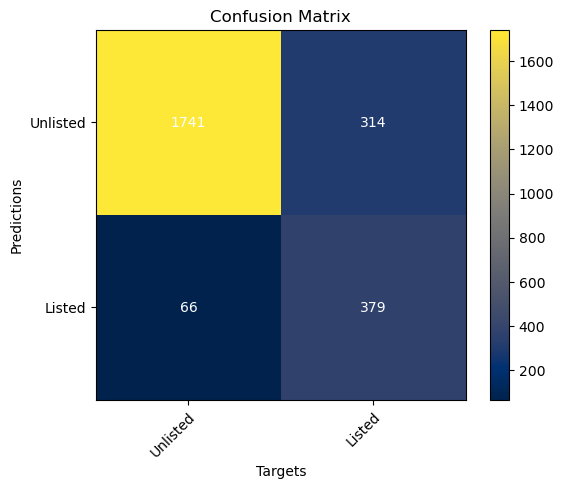

In [55]:
model_xgb.fit(X_combined_bow, y_train)

# Predicting
y_pred_xgb = model_xgb.predict(X_combined_bow_val)

# Evaluation
print(classification_report(y_pred_xgb, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_xgb, y_val), labels.keys())

<hr>
<a class="anchor" id="boost_1gram">
    
### 5.5.2. TF-IDF (1-Gram)
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.96      0.86      0.91      2034
      Listed       0.58      0.86      0.69       466

    accuracy                           0.86      2500
   macro avg       0.77      0.86      0.80      2500
weighted avg       0.89      0.86      0.87      2500



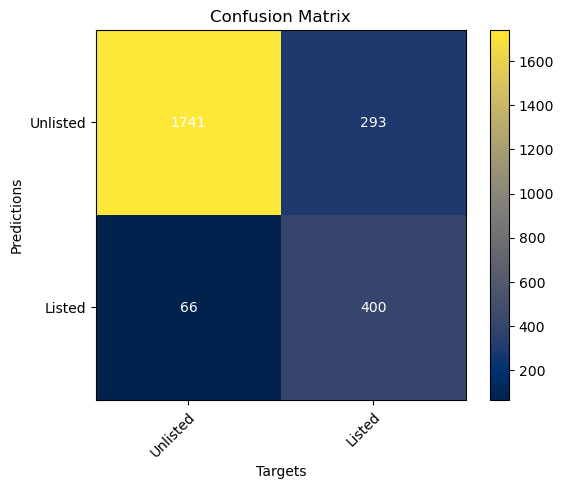

In [56]:
model_xgb.fit(X_combined_tfidf, y_train)

# Predicting
y_pred_xgb = model_xgb.predict(X_combined_tfidf_val)

# Evaluation
print(classification_report(y_pred_xgb, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_xgb, y_val), labels.keys())

<hr>
<a class="anchor" id="boost_2gram">
    
### 5.5.3. TF-IDF (2-Gram)
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.97      0.86      0.91      2030
      Listed       0.59      0.88      0.71       470

    accuracy                           0.86      2500
   macro avg       0.78      0.87      0.81      2500
weighted avg       0.90      0.86      0.87      2500



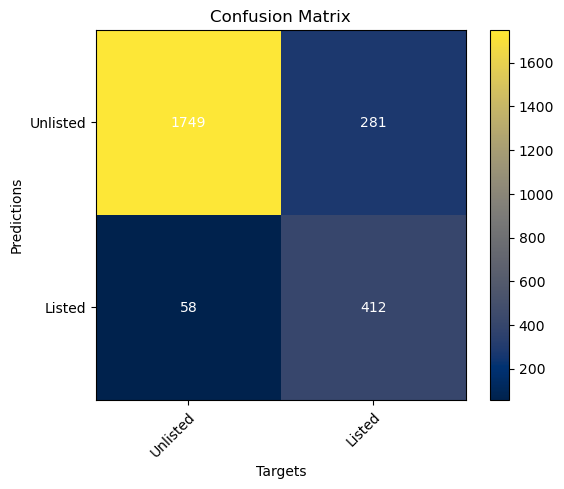

In [57]:
model_xgb.fit(X_combined_tfidf_2g, y_train)

# Predicting
y_pred_xgb = model_xgb.predict(X_combined_tfidf_val_2g)

# Evaluation
print(classification_report(y_pred_xgb, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_xgb, y_val), labels.keys())

<hr>
<a class="anchor" id="boost_hash">
    
### 5.5.4. Hashing Vectorizer
    
</a>

Based on **description, host_about and comments**:

              precision    recall  f1-score   support

    Unlisted       0.96      0.85      0.91      2035
      Listed       0.57      0.85      0.69       465

    accuracy                           0.85      2500
   macro avg       0.77      0.85      0.80      2500
weighted avg       0.89      0.85      0.86      2500



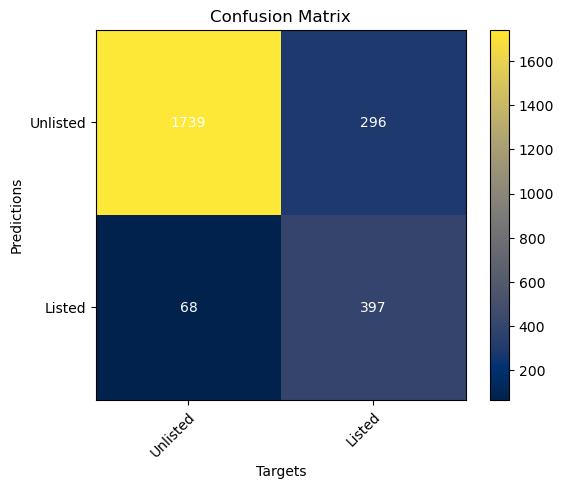

In [58]:
model_xgb.fit(X_combined_hash, y_train)

# Predicting
y_pred_xgb = model_xgb.predict(X_combined_hash_val)

# Evaluation
print(classification_report(y_pred_xgb, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_xgb, y_val), labels.keys())

<hr>
<a class="anchor" id="boost_custom">
    
### 5.5.5. Custom Features
    
</a>

In [ ]:
model_xgb.fit(x_train_custom, y_train)

# Predicting
y_pred_xgb = model_xgb.predict(x_val_custom)

# Evaluation
print(classification_report(y_pred_xgb, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_xgb, y_val), labels.keys())

<hr>
<a class="anchor" id="gridsearch">
    
## 5.7. Grid Search
    
</a>

In [64]:
parameter_space = {
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'learning_rate_init': [0.001, 0.01]
}

In [65]:
clf = GridSearchCV(model_nn, parameter_space)

In [ ]:
clf.fit(X_combined_bow, y_train)

In [ ]:
clf.best_params_

In [ ]:
final_model = clf.best_estimator_.fit(X_combined_bow, y_train)
print('Train:', final_model.score(X_combined_bow, y_train))
print('Test:', final_model.score(X_combined_bow_val, y_val))

In [ ]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

<hr>
<a class="anchor" id="test">
    
# 6. Test
    
</a>

In [ ]:
###
### MAKING PREDICTIONS ON TEST (UNSEEN) DATA
###

In [6]:
### PROCESSING TEST DATA

# Read .xlsx 
airbnb_df_test = pd.read_excel('Project Corpora/test.xlsx')
airbnb_df_test.to_csv('output/test.csv', index=False)

# Savw to .csv to process later in chunks
reviews_df_test = pd.read_excel('Project Corpora/test_reviews.xlsx')
reviews_df_test.to_csv('output/test_reviews.csv', index=False)

In [7]:
### TEST DATA >>> DETECTING LANGUAGES

In [8]:
# Detecting languages in the TEST dataset >>>>>>>>>>> RUN THIS ONLY ONCE: IT APPENDS IN THE END OF FILE
source_file = 'output/test.csv'
destination_file = 'output/test_with_language.csv'

chunk_size = 500
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    chunk['description'] = chunk['description'].str.replace('<br/>', '')
    chunk['description'] = chunk['description'].str.replace('x000D', '')
    chunk['description_language'] = chunk['description'].apply(detect_language)
    
    chunk['host_about'] = chunk['host_about'].str.replace('<br/>', '')
    chunk['host_about'] = chunk['host_about'].str.replace('x000D', '')
    chunk['host_about_language'] = chunk['host_about'].apply(detect_language)
    
    chunk.to_csv(destination_file, 
                 index=False, 
                 mode='a', 
                 header=not os.path.exists(destination_file))

3it [00:07,  2.38s/it]


In [9]:
# Detecting languages in the TEST Reviews dataset >>>>>>>>>>> RUN THIS ONLY ONCE: IT APPENDS IN THE END OF FILE
source_file = 'output/test_reviews.csv'
destination_file = 'output/test_reviews_with_language.csv'

chunk_size = 500
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    chunk['comments'] = chunk['comments'].str.replace('<br/>', '')
    chunk['comments'] = chunk['comments'].str.replace('x000D', '')
    chunk['comments_language'] = chunk['comments'].apply(detect_language)
    
    chunk.to_csv(destination_file, 
                 index=False, 
                 mode='a', 
                 header=not os.path.exists(destination_file))

162it [02:29,  1.08it/s]


In [ ]:
### TEST DATA >>> REMOVING HTML TAGS

In [13]:
airbnb_language_df = pd.read_csv('output/test_with_language.csv')
reviews_languages_df = pd.read_csv('output/test_reviews_with_language.csv')

# Applying the function above to remove HTML tags 
clean_airbnb_df = remove_HTML_tags(airbnb_language_df, 'description')
clean_airbnb_df = remove_HTML_tags(clean_airbnb_df,'host_about')

clean_reviews_df = remove_HTML_tags(reviews_languages_df,'comments')

In [ ]:
### TEST DATA >>> TRANSLATION

In [14]:
## Translating 'description' column, creating a new column 'description_english'

# Taking descriptions values and their detected languages
descriptions = clean_airbnb_df.description
description_languages = clean_airbnb_df.description_language

# Generating values for the new 'description_english' column
description_english = []

for i in tqdm(range(len(descriptions))):
    if description_languages[i] == 'en':
        description_english.append(descriptions[i])
    else:
        sentences = split_text_into_sentences(descriptions[i]) # Split text into sentences/chunks
        translated_sentences = translate_text_chunks(sentences) # Translate each sentence/chunk
        translated_output = " ".join(translated_sentences) # Merge translated sentences/chunks
        description_english.append(translated_output)
        
# Add a new column to train_df
clean_airbnb_df['description_english'] = description_english

clean_airbnb_df.tail(5)

100%|███████████████████████████████████████| 1389/1389 [15:15<00:00,  1.52it/s]


,index,description,host_about,description_language,host_about_language,description_english
1384,1385,O melhor ponto de partida para descobrir Lisbo...,I work in Hospitality and I love traveling.__ ...,pt,en,The best starting point to discover Lisbon! To...
1385,1386,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b...",en,en,Casa de Baixo is a cozy and comfortable apartm...
1386,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...",en,en,Beautiful and peaceful apartment with a superb...
1387,1388,The apartment in Lisbon has capacity for 2 peo...,We are Feels Like Home Holiday Rentals. A comp...,en,en,The apartment in Lisbon has capacity for 2 peo...
1388,1389,Appartement situé à 5 minutes à pieds du magni...,Franco-Autrichien,fr,it,Apartment located 5 minutes walk from the magn...


In [22]:
# Anomaly detected while translating host_about in test dataset, 
# So, we will deal with it below:
cleaned_anomaly = "I’m very enthusiastic at the idea of welcoming you and sharing with you the riches of the most poetical city in Europe. After many years spent abroad (Cuba, Central America, West Africa, Brazil…) far away from home (Paris) I literally fell in love with Lisbon and decided to make it my permanent residence. “But why?” one is about to say… Well, as soon as I arrived, I felt like a fish in the water and I  couldn’t resist the sight of this sleeping beauty along the Tagus river, in a golden light… the warmth of the Portuguese people, the charm of neighborhoods that belong to the past, the mystery of the narrow and winding cobbled streets, the decadent beauty of palaces, of churches and convents … and this amazing contrast between  Lisbon, city of the past with Lisbon, city of the future, with its suspended Vasco da Gama bridge and the expo 1998 site.You’ll be under the spell like I was and still am and I can promise you that you’ll cherish the memories of your stay in Lisbon!"

clean_airbnb_df.at[258, 'host_about'] = cleaned_anomaly
clean_airbnb_df.at[1146, 'host_about'] = cleaned_anomaly

In [23]:
## Translating 'host_about' column, creating a new column 'host_about_english', 
## and storing dataset for the future


# Taking 'host_about' values and their detected languages
host_abouts = clean_airbnb_df.host_about
host_about_languages = clean_airbnb_df.host_about_language

# Generating values for the new 'host_about_english' column
host_about_english = []

for i in tqdm(range(len(host_abouts))):
    if host_about_languages[i] == 'en':
        host_about_english.append(host_abouts[i])
    else:
        sentences = split_text_into_sentences(host_abouts[i]) # Split text into sentences/chunks
        translated_sentences = translate_text_chunks(sentences) # Translate each sentence/chunk
        translated_output = " ".join(translated_sentences) # Merge translated sentences/chunks
        host_about_english.append(translated_output)
        
# Add a new column to train_df
clean_airbnb_df['host_about_english'] = host_about_english

# Saving to final file
clean_airbnb_df.to_csv('output/test_translated.csv', index=False)

clean_airbnb_df.tail(5)

100%|███████████████████████████████████████| 1389/1389 [25:19<00:00,  1.09s/it]


,index,description,host_about,description_language,host_about_language,description_english,host_about_english
1384,1385,O melhor ponto de partida para descobrir Lisbo...,I work in Hospitality and I love traveling.__ ...,pt,en,The best starting point to discover Lisbon! To...,I work in Hospitality and I love traveling.__ ...
1385,1386,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b...",en,en,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b..."
1386,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...",en,en,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol..."
1387,1388,The apartment in Lisbon has capacity for 2 peo...,We are Feels Like Home Holiday Rentals. A comp...,en,en,The apartment in Lisbon has capacity for 2 peo...,We are Feels Like Home Holiday Rentals. A comp...
1388,1389,Appartement situé à 5 minutes à pieds du magni...,Franco-Autrichien,fr,it,Apartment located 5 minutes walk from the magn...,Franco-Autrichien
